# Customer Segmentation Analysis

## Project Overview

The objective of this analysis is to understand customer purchasing behaviors through segmentation, allowing for targeted marketing initiatives and improved customer service.

## Dataset Summary

- **Total Observations**: 35,116
- **Features**: 8 initial features, expanded through feature engineering.
- **Data Challenges**: Addressed missing values, anomalies, and complex feature space.

## Data Cleaning and Feature Engineering

- **Handling Missing Values and Outliers**: Cleaned data by excluding entries with incomplete 'CustomerID' and adjusting for extreme variations in 'Quantity' and 'UnitPrice'.
- **Customer-Level Feature Engineering**: Generated features encapsulating customer activity, such as:
  - Frequency and recency of purchases
  - Average and variability in shopping cart value
  - Overall spending behavior
- **Cart-Level Feature Engineering**: Derived attributes to summarize shopping cart trends, including metrics on the value and diversity of products per purchase.
- **Country-Level Feature Engineering**: Aggregated data by country to incorporate geographical patterns and trends into the segmentation process.
- **Dimensionality Reduction**: Applied PCA to the 'StockCode' features to extract item-level characteristics and reduce dimensionality while preserving critical information.

## Clustering Techniques

### K-Means Clustering
Experiments were conducted with 3, 4, and 5 clusters, with the 5-cluster solution providing the best balance between cluster cohesion and separation according to silhouette scores.

### Hierarchical Clustering
Evaluated using 3 to 5 clusters to uncover hierarchical relationships, with higher cluster counts revealing more granular, well-defined customer segments.

### DBSCAN
Considered for its unique approach to clustering based on density, but less effective due to the dataset's variance in density.

## Key Findings and Scoring

- K-Means and Hierarchical Clustering analyses with 3, 4, and 5 clusters each provided valuable insights, with 5 clusters achieving the most favorable results in both methods.
- The silhouette score was highest for the 5-cluster K-Means model, indicating clear delineation among segments.
- Hierarchical Clustering with 5 clusters confirmed the presence of well-separated customer profiles within the data hierarchy.

## Conclusions

- The segmentation revealed actionable customer profiles for targeted marketing efforts and strategic customer service enhancements.
- Country-level and item-level features, such as those derived from 'Country' and 'StockCode', were pivotal in capturing comprehensive customer behavior patterns.
- The optimal number of clusters, identified through both K-Means and Hierarchical Clustering, underscored the complexity and diversity within the customer base.



## Library Imports:

In [1]:
import numpy as np
import pandas as pd
# Increase Pandas Max Display Columns
pd.set_option('display.max_columns', 100)

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix

from scipy.stats import zscore

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

import scipy.cluster.hierarchy as sch

## Exploratory Analysis:

In [2]:
df = pd.read_csv('../data/train.csv')

In [3]:
df.shape

(35116, 8)

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France


In [5]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
35111,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/11 12:50,0.85,12680.0,France
35112,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France
35113,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France
35114,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France
35115,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/11 12:50,4.95,12680.0,France


In [6]:
# Check for null values
df.isna().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     1418
Country           0
dtype: int64

In [7]:
df.describe()

,InvoiceNo,Quantity,UnitPrice,CustomerID
count,35116.000000,35116.000000,35116.000000,33698.000000
mean,559940.650273,14.624302,4.700512,12793.819188
std,12645.318619,31.144229,51.807988,828.171434
min,536370.000000,1.000000,0.040000,12347.000000
25%,548737.000000,5.000000,1.250000,12473.000000
50%,561037.000000,10.000000,1.950000,12597.000000
75%,570672.000000,12.000000,3.750000,12708.000000
max,581587.000000,2040.000000,4161.060000,17844.000000


In [8]:
df.describe(include='object')

,StockCode,Description,InvoiceDate,Country
count,35116,35116,35116,35116
unique,2602,2669,1577,37
top,POST,POSTAGE,10/11/11 14:52,Germany
freq,1057,1057,259,9040


In [9]:
df.dtypes

InvoiceNo        int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [10]:
df.groupby('CustomerID').CustomerID.nunique().sum()

414

In [11]:
df.groupby('InvoiceNo').InvoiceNo.nunique().sum()

1591

In [12]:
(df.groupby('Country').InvoiceNo.nunique() > 20).sum()

14

In [13]:
df.groupby('CustomerID').nunique().sum()

InvoiceNo       1536
StockCode      25099
Description    25199
Quantity        4411
InvoiceDate     1535
UnitPrice       7677
Country          422
dtype: int64

### Initial Observations Based on the EDA:

- **Data Structure**: The dataset consists of 35,116 observations across 8 features.
- **Missing Values**: There are 1,418 records missing the "CustomerID" which will need to be dropped.
- **Quantity**: For the "Quantity" feature, 75% of the values are 12 or less, but there's a maximum value of 2,040, indicating potential outliers.
- **Unit Price**: Similarly, the "UnitPrice" column has 75% of its values at 3.75 or less, with a maximum value of 4,161.06, suggesting possible outliers.
- **Categorical Features**:
  - "StockCode" and "Description" have many unique values; we may apply one-hot encoding followed by PCA for dimensionality reduction.
  - "Country" also has numerous unique values; the approach could involve flagging the top 5 countries and grouping the rest into an 'Other' category.
- **Date and Time**:
  - "InvoiceDate" is in the format "MM/DD/YY HH:MM" and will be used to engineer features that capture temporal information.
- **Data Types**: The "CustomerID" is currently a float but should be converted to an int for better memory efficiency.
- **Customer Insights**: There are 414 unique customers, which presents an opportunity for feature engineering at the customer level.
- **Transaction Insights**: With 1,591 unique transactions, there is potential to engineer features based on transaction or cart data.

## Data preprocessing & Feature Engineering

### Data preprocessing

In [14]:
# Function to flag and cap outliers based on z-score
def handle_outliers(column):
    # Calculate z-scores
    z_scores = np.abs(zscore(column))
    
    # Step 1: Flagging Outliers
    is_outlier = z_scores > 3
    
    # Convert boolean flags to integer
    is_outlier = is_outlier.astype(int)
    
    # Step 2: Capping Outliers
    # Using the 3rd standard deviation as the cap
    upper_cap = column.mean() + 3*column.std()
    lower_cap = column.mean() - 3*column.std()
    
    capped_column = np.where(z_scores > 3, upper_cap, column)
    capped_column = np.where(is_outlier & (column < lower_cap), lower_cap, capped_column)
    
    return capped_column, is_outlier


In [15]:
# Handling Missing Values
df = df.dropna(subset=['CustomerID'])  # Dropping rows where 'CustomerID' is missing

# Changing CustomerID type to int
df['CustomerID'] = df.CustomerID.astype(int)

# Capping and flagging Outliers for Quantity and UnitPrice
df['Quantity'], df['Outlier_Quantity'] = handle_outliers(df['Quantity'])
df['UnitPrice'], df['Outlier_UnitPrice'] = handle_outliers(df['UnitPrice'])

# Creating the Sales feature
df['Sales'] = df['Quantity'] * df['UnitPrice']

# Handling outliers in Sales
df['Sales'], df['Outlier_Sales'] = handle_outliers(df['Sales'])

### Feature Engineering

In [16]:
# Group by CustomerID aggregate
invoice_data = df.groupby('CustomerID').InvoiceNo.agg(['nunique'])
invoice_data.columns = ['total_transactions']

product_data = df.groupby('CustomerID').StockCode.agg(['count', 'nunique'])
product_data.columns = ['total_products', 'total_unique_products']

sales_data = df.groupby('CustomerID').Sales.agg(['sum', 'mean'])
sales_data.columns = ['total_sales', 'avg_product_value']

outlier_data = df.groupby('CustomerID')[['Outlier_Quantity', 'Outlier_UnitPrice', 'Outlier_Sales']].agg(['sum'])
outlier_data.columns = ['Outlier_Quantity', 'Outlier_UnitPrice', 'Outlier_Sales']
outlier_data['pct_quantity_outliers'] = outlier_data['Outlier_Quantity'] / product_data['total_products']
outlier_data['pct_price_outliers'] = outlier_data['Outlier_UnitPrice'] / product_data['total_products']
outlier_data['pct_sales_outliers'] = outlier_data['Outlier_Sales'] / product_data['total_products']

In [17]:
# Group by CustomerID cart
cart_data = df.groupby(['CustomerID', 'InvoiceNo']).Sales.agg(['sum'])
cart_data.columns = ['cart_value']
cart_data.reset_index(inplace=True)
agg_cart_data = cart_data.groupby('CustomerID').cart_value.agg(['mean', 'min', 'max'])
agg_cart_data.columns = ['avg_cart_value', 'min_cart_value', 'max_cart_value']

In [18]:
# Country aggregation
top_countries = df['Country'].value_counts().head(5).index
df['Country_aggregated'] = df['Country'].apply(lambda x: x if x in top_countries else 'Other')
country_data = df.groupby(['CustomerID', 'Country_aggregated']).InvoiceNo.count().unstack(fill_value=0)
country_data.columns = ['country_' + str(col) for col in country_data.columns]

In [19]:
# Aggregating Recency: the minimum recency per customer as it will be same for all transactions of a customer
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # Ensure the InvoiceDate is in datetime format
max_invoice_date = df['InvoiceDate'].max()  # Get the maximum invoice date in the dataset
df['Recency'] = (max_invoice_date - df.groupby('CustomerID')['InvoiceDate'].transform('max')).dt.days
recency_data = df.groupby('CustomerID')['Recency'].min()
recency_data.columns = ['Recency']

In [20]:
# PCA for StockCode
stockcode_dummies = pd.get_dummies(df['StockCode'], prefix='StockCode')
stockcode_dummies['CustomerID'] = df['CustomerID']  # Attaching CustomerID to stockcode_dummies
item_data = stockcode_dummies.groupby('CustomerID').sum()

# Scaling
stockcode_scaler = StandardScaler()
item_data_scaled = stockcode_scaler.fit_transform(item_data)

# Applying PCA
pca = PCA(n_components=0.80)
pca_features = pca.fit_transform(item_data_scaled)

# Creating DataFrame for PCA features
items_pca = pd.DataFrame(pca_features, columns=['PC{}'.format(i + 1) for i in range(pca_features.shape[1])])
items_pca.index = item_data.index  # Setting CustomerID as the index

Text(0.5, 1.0, 'Scree Plot')

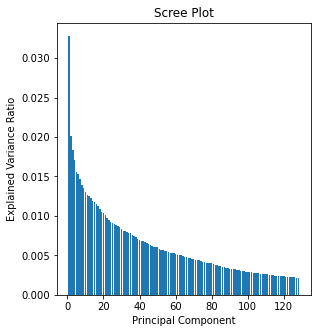

In [21]:
# Scree plot
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance)+1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

In [22]:
# Join all new datasets together to a customer DF
joined_df = invoice_data.join([product_data,
                               sales_data,
                               outlier_data,
                               agg_cart_data,
                               country_data,
                               recency_data,
                               items_pca
                              ],
                              how='left').fillna(0)

In [23]:
joined_df.shape

(414, 149)

In [24]:
df_labeled = joined_df.copy()

In [25]:
df_labeled.shape

(414, 149)

### Data Preprocessing and Feature Engineering Summary

#### Data Cleaning

- Missing values for `CustomerID` were removed to maintain the integrity of the dataset.
- The `CustomerID` data type was converted from float to int for better memory efficiency.

#### Outlier Handling

- Outliers in `Quantity`, `UnitPrice`, and `Sales` were identified using z-scores and capped at 3 standard deviations from the mean.
- Outlier flags were added to indicate which entries were modified.

#### Feature Creation

- **Sales Feature**: Calculated by multiplying `Quantity` by `UnitPrice`.
- **Customer-Level Aggregations**:
  - **Transactions**: The unique number of invoices per customer.
  - **Products**: Count and number of unique stock codes per customer.
  - **Sales**: Total and average sales per customer.
  - **Outliers**: Proportion of quantity, unit price, and sales outliers per customer.
- **Cart-Level Aggregations**:
  - Average, minimum, and maximum cart values were computed for each customer.

#### Country Feature Engineering

- The dataset was simplified by grouping countries into top 5 countries and others.
- New features were created to capture the number of invoices per country for each customer.

#### Recency Feature

- Recency was calculated for each customer based on the most recent invoice date.

#### PCA on StockCode

- One-hot encoding was applied to `StockCode` to prepare for PCA.
- The PCA reduced the dimensionality of item-level features, retaining components that explained 80% of the variance.
- PCA features were scaled and joined to the main dataset.

#### Final Dataset Compilation

- The processed features were joined to form a comprehensive customer-level dataset ready for analysis.

# Clustering: K-Mean, Hierarchical, DBSCAN


In [26]:
#Common functionsto use for clustering

def fit_kmeans(data, n_clusters):
    """
    Fit KMeans clustering.
    
    Parameters:
        data (DataFrame): The data to cluster.
        n_clusters (int): The number of clusters to form.
        
    Returns:
        tuple: Cluster labels and cluster centers.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    return kmeans.labels_, kmeans.cluster_centers_

def show_cluster_sizes(labels):
    """
    Show the sizes of each cluster.
    
    Parameters:
        labels (array): Cluster labels.
    """
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    print(f"Cluster Sizes for {len(cluster_sizes)} clusters:")
    print(cluster_sizes)

def feature_analysis(data, labels, n_top_features=20):
    """
    Perform feature analysis across clusters and plot the results.
    
    Parameters:
        data (DataFrame): The original data.
        labels (array): Cluster labels.
        n_top_features (int): Number of top features to display.
    """
    data_with_clusters = data.copy()
    data_with_clusters['cluster_labels'] = labels
    cluster_means = data_with_clusters.groupby('cluster_labels').mean()
    
    # Get the mean value for each feature in clusters
    overall_mean = cluster_means.mean(axis=0).sort_values(ascending=False)
    top_features = overall_mean.head(n_top_features).index 
    
    for feature in top_features:
        plt.figure(figsize=(8, 5))
        sns.barplot(x=cluster_means.index, y=cluster_means[feature])
        plt.title(f'Feature: {feature} Across Clusters')
        plt.xlabel('Cluster')
        plt.ylabel('Mean Value')
        plt.tight_layout()
        plt.show()

def pca_2d_visualization(data, labels, centroids=None):
    """
    Perform PCA for 2D visualization of clustering and plot the results.
    
    Parameters:
        data (DataFrame): The original data.
        labels (array): Cluster labels.
        centroids (array): Centroids of clusters, if available.
    """
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data)
    
    #plt.figure(figsize=(10, 8))
    sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=labels, palette='viridis')
    
    if centroids is not None:
        centroids_pca = pca.transform(centroids)
        plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, c='red')
    
    plt.title('2D PCA Clustering Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.show()

def hierarchical_clustering(data, n_clusters):
    """
    Perform hierarchical clustering and return labels.
    
    Parameters:
        data (DataFrame): The data to cluster.
        n_clusters (int): The number of clusters.
        
    Returns:
        array: Cluster labels.
    """
    hc = AgglomerativeClustering(n_clusters=n_clusters)
    labels = hc.fit_predict(data)
    sil_score = silhouette_score(data, labels)
    print(f"Silhouette Score for {n_clusters} Clusters: {sil_score}")
    return labels

def pca_for_visualization(data, labels):
    """
    Apply PCA for visualization purposes and return a DataFrame with PCA components and labels.
    
    Parameters:
        data (DataFrame): The data to apply PCA on.
        labels (array): Cluster labels.
        
    Returns:
        DataFrame: A DataFrame with principal components and cluster labels.
    """
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)
    visual_df = pd.DataFrame(data=principal_components,
                             columns=['principal component 1', 'principal component 2'])
    visual_df['Cluster'] = labels
    return visual_df


## K-Mean Clustering 

In [27]:
df_kmean = joined_df.copy()

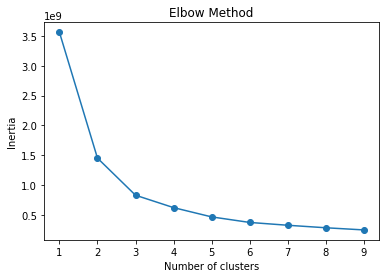

In [28]:
inertias = []
range_values = range(1, 10)

for k in range_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_kmean)
    inertias.append(kmeans.inertia_)

plt.plot(range_values, inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


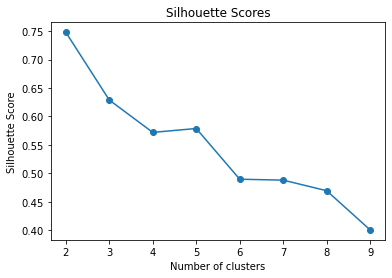

In [29]:
sil_scores = []
range_values = range(2, 10)

for k in range_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_kmean)
    labels = kmeans.labels_
    sil_scores.append(silhouette_score(df_kmean, labels))

plt.plot(range_values, sil_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


### Clustering Observations

- **Inertia/Elbow Method Analysis:**
  - The Inertia/Elbow method suggests that 3, 4, and 5 clusters are optimal as the rate of decrease in inertia significantly slows down after 5 clusters, indicating a diminishing return on the fit of additional clusters.

- **Silhouette Score Comparison:**
  - The Silhouette Score for 3 clusters is approximately 0.64, compared to around 0.57 for both 4 and 5 clusters.
  - This higher silhouette score implies that the 3-cluster solution has, on average, better-defined clusters, making it a strong candidate for the k-Means implementation.


### K-Means: 3 Clusters

In [30]:
# For fitting KMeans
n_clusters = labels = centroids = None
n_clusters = 3
df_kmean_3_clusters = joined_df.copy()
labels, centroids = fit_kmeans(df_kmean_3_clusters, n_clusters)

#To save labels to compare later
df_labeled['kmean_3'] = labels

In [31]:
# Showing cluster sizes
labels, centroids = fit_kmeans(df_kmean_3_clusters, n_clusters)
show_cluster_sizes(labels)

Cluster Sizes for 3 clusters:
0     83
1    315
2     16
dtype: int64


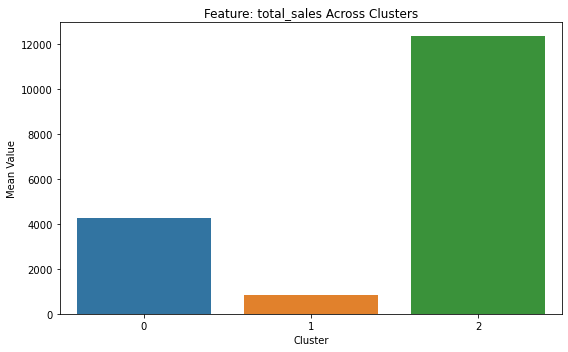

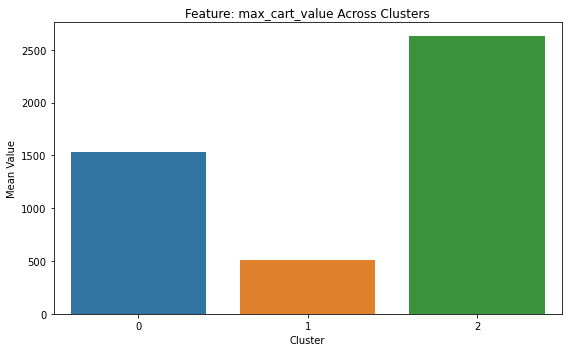

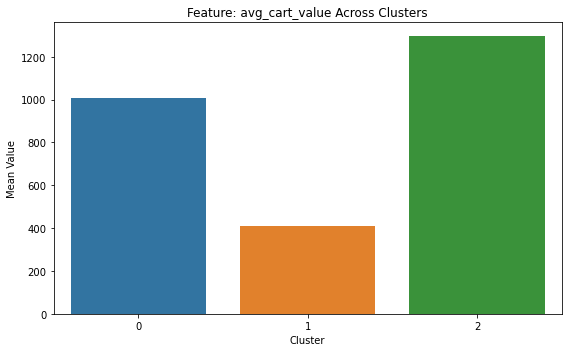

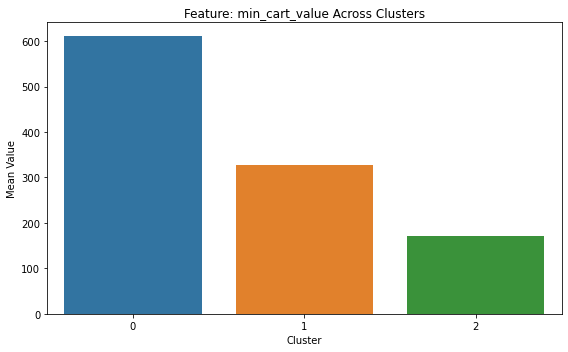

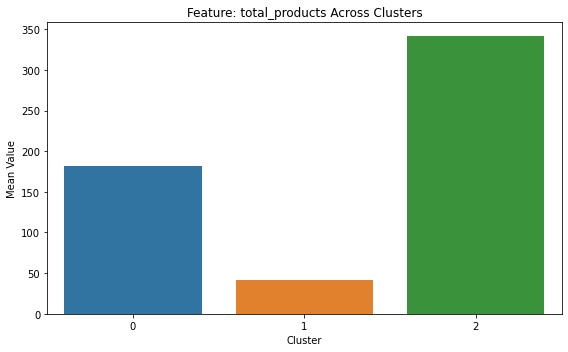

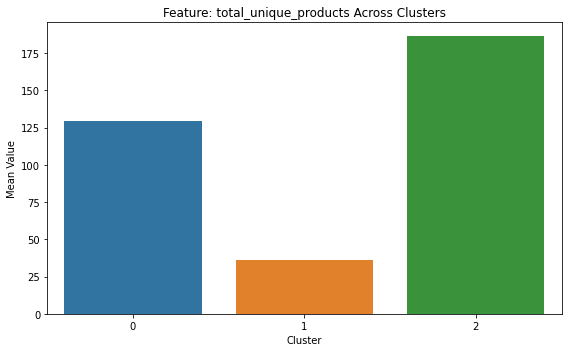

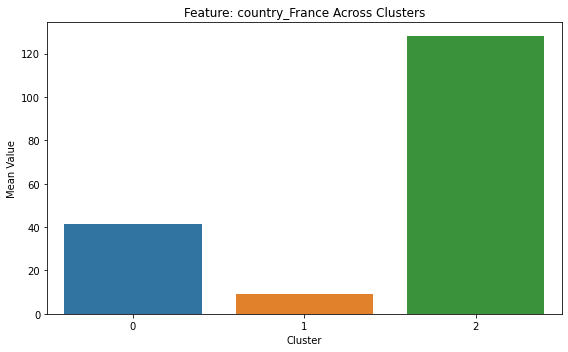

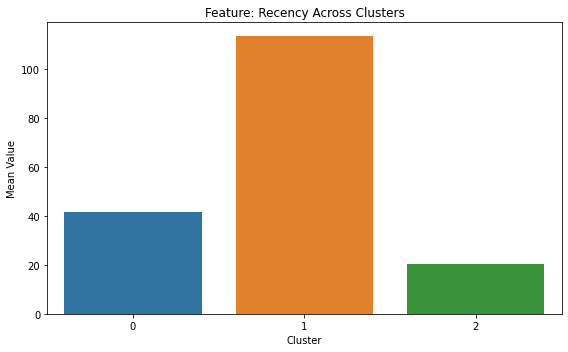

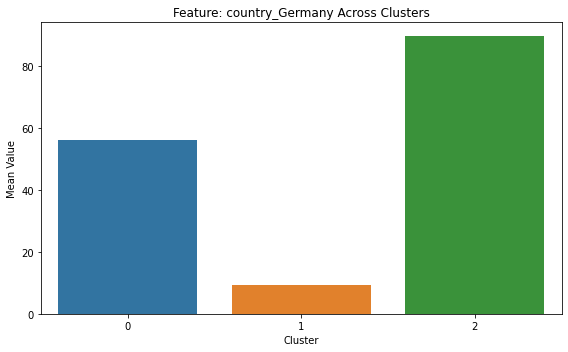

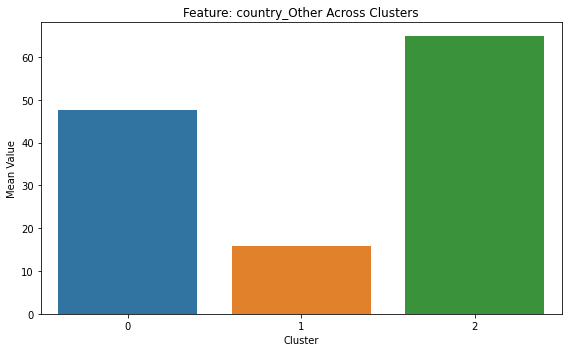

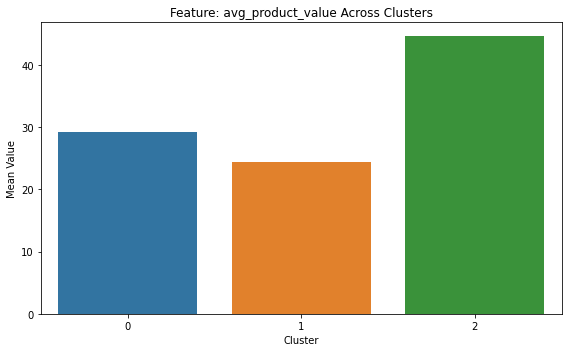

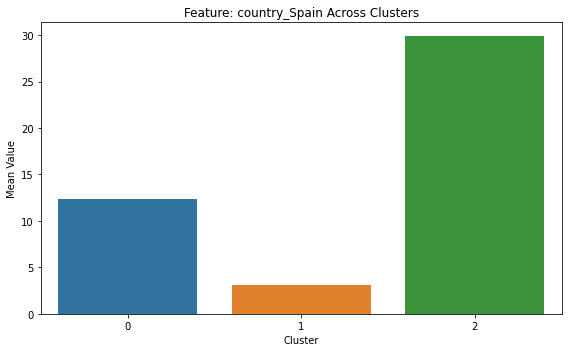

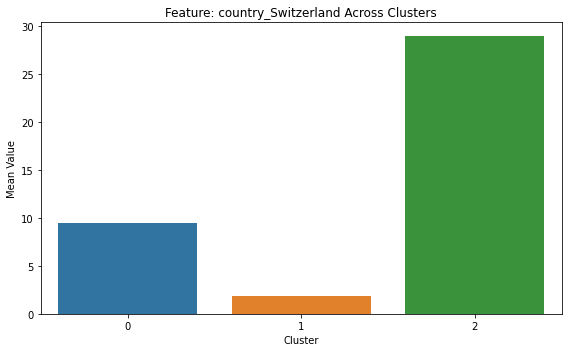

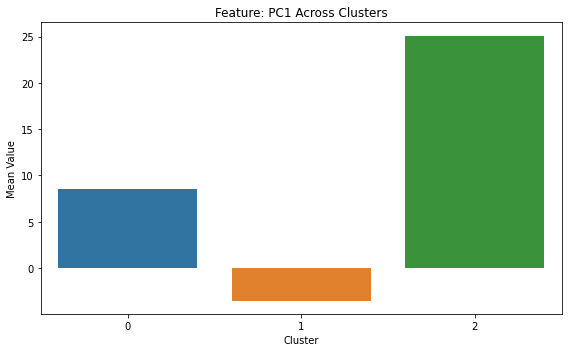

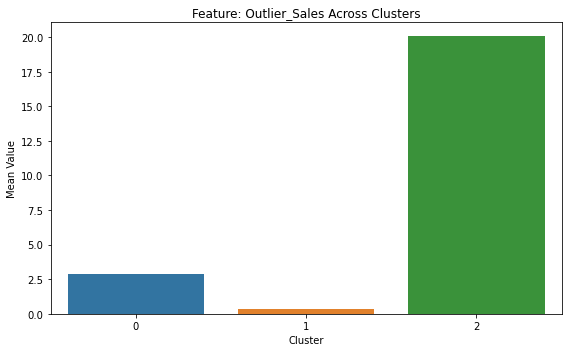

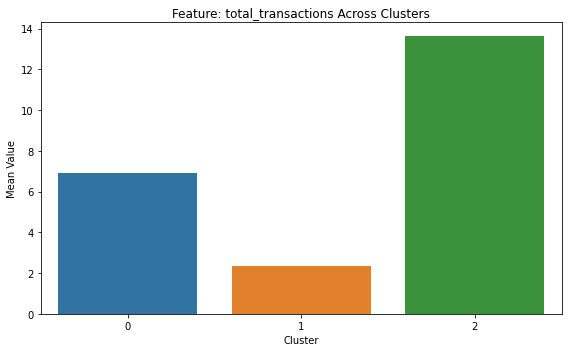

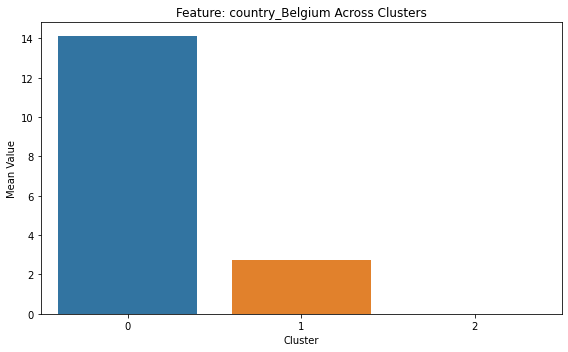

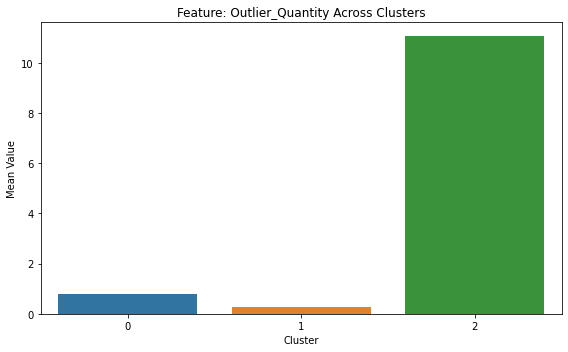

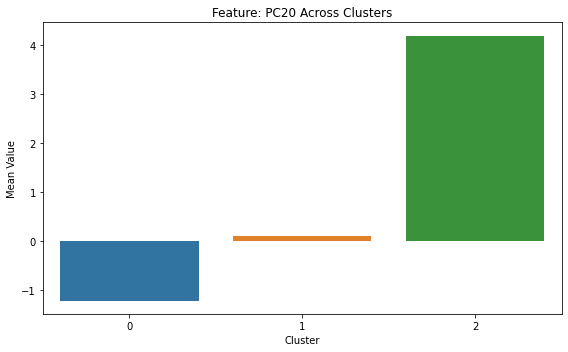

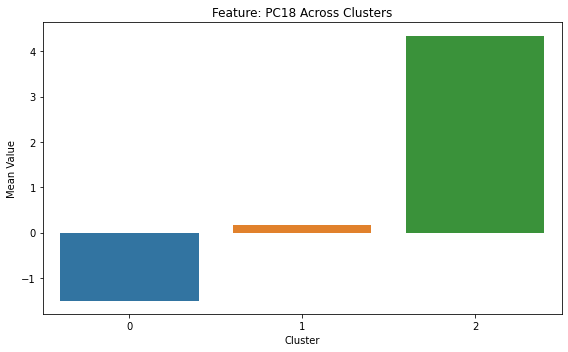

In [32]:
# For top 20 feature analysis
feature_analysis(df_kmean_3_clusters, labels)

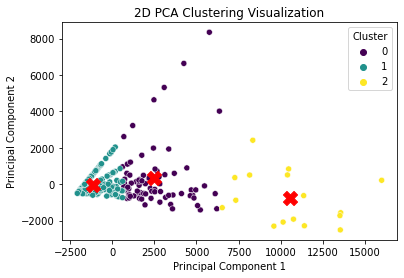

In [33]:
pca_2d_visualization(df_kmean_3_clusters, labels, centroids)

### K-Means Clustering Observations: 3 Clusters

#### 1. **Cluster Sizes and General Interpretation**
   - **Cluster 1 (Size: 315):** 
     - Likely captures the most common customer behaviors or characteristics in the dataset.
     - Represents a primary target for generalized marketing strategies.
     
   - **Cluster 0 (Size: 83):**
     - Medium-sized cluster representing specific customer segments that aren’t predominant.
     - Could be a focus for more specialized, targeted marketing strategies.
     
   - **Cluster 2 (Size: 16):**
     - Smallest cluster, possibly representing niche markets or outliers.
     - Strategy could include personalized services/products or consider as outliers.

#### 2. **Feature Analysis**
   - **General Spending Patterns:**
     - Cluster 2 shows a trend of higher spending, more products purchased, and diverse buying.

   - **Outliers Analysis:**
     - Cluster 2 tends to have higher values in outlier-flagged columns.

   - **Geographical Location:**
     - Different patterns observed, with Belgium standing out in Cluster 0.
   
   - **Recency of Purchases:**
     - Customers in Cluster 2 and Cluster 0 have made purchases more recently.
   
   - **Principal Component Analysis (PCA):**
     - PCA components align well with identified spending patterns, especially in Cluster 2.
   
#### 3. **Three Clusters Visualization**
   - The clusters are distinct based on the first principal component (PC1).
   - Clusters 0 and 2 appear somewhat sparse based on the second principal component (PC2), while Cluster 1 is dense and well-separated along both PCs.
   - Notable outliers, particularly in Cluster 0 with respect to PC2, are evident.

### K-Means: 4 Clusters

In [34]:
# For fitting KMeans
n_clusters = labels = centroids = None
n_clusters = 4
df_kmean_4_clusters = joined_df.copy()
labels, centroids = fit_kmeans(df_kmean_4_clusters, n_clusters)

#To save labels to compare later
df_labeled['kmean_4'] = labels

In [35]:
# Showing cluster sizes
labels, centroids = fit_kmeans(df_kmean_4_clusters, n_clusters)
show_cluster_sizes(labels)

Cluster Sizes for 4 clusters:
0    285
1     11
2     91
3     27
dtype: int64


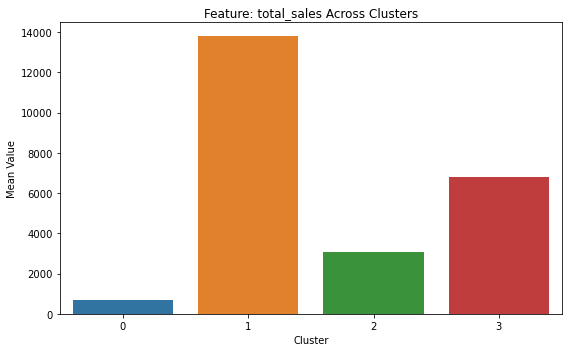

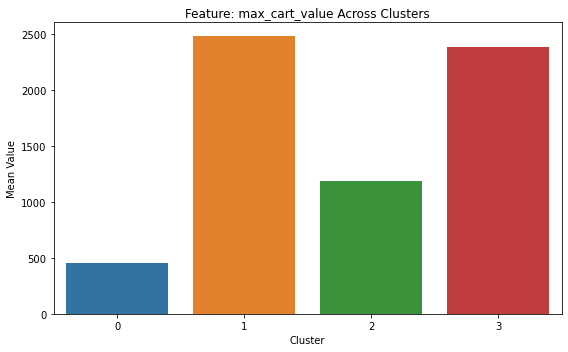

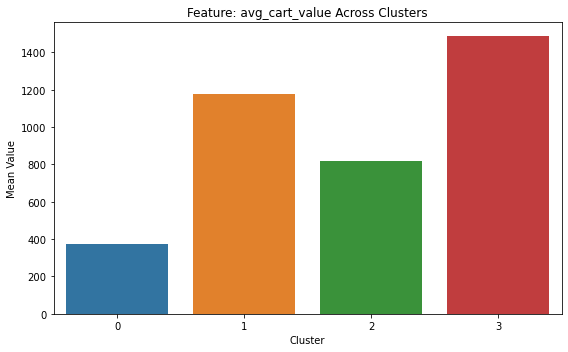

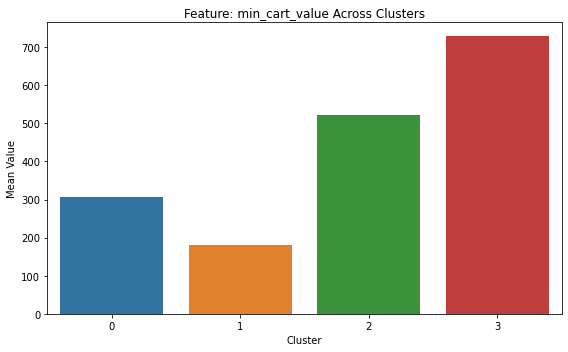

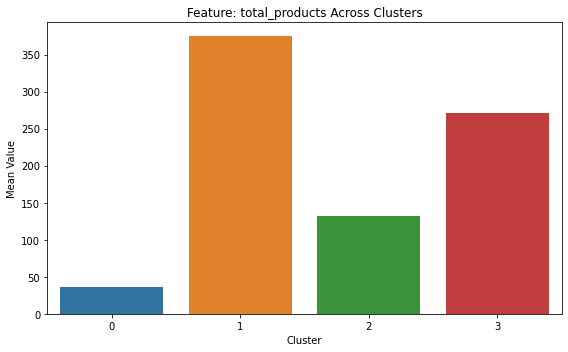

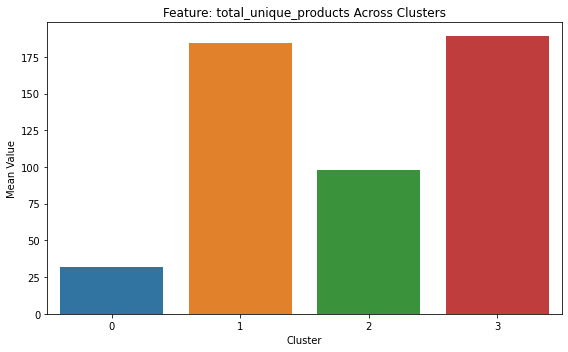

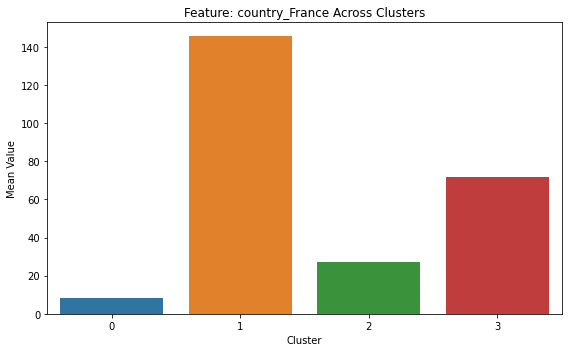

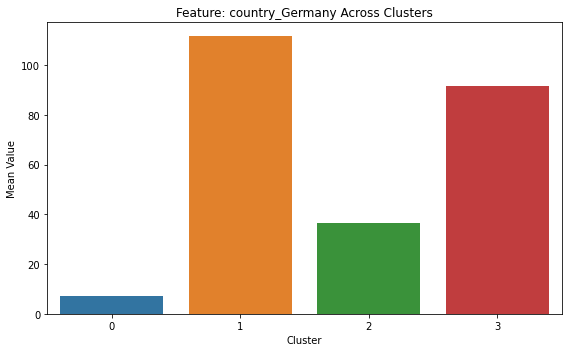

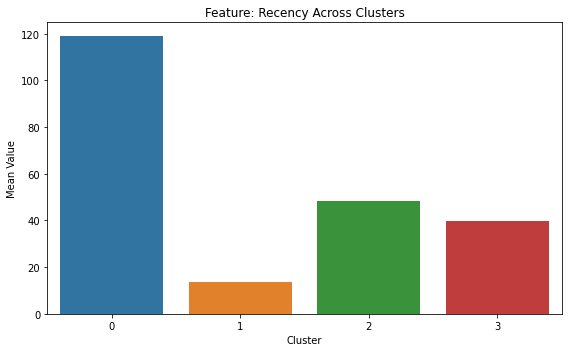

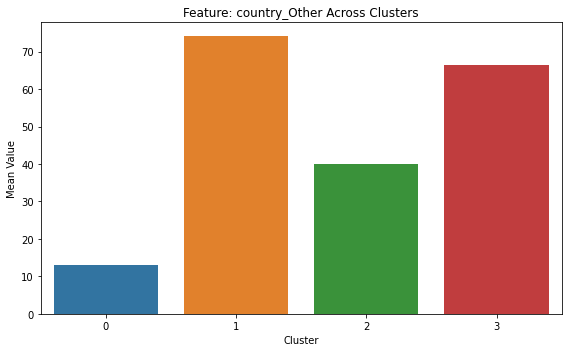

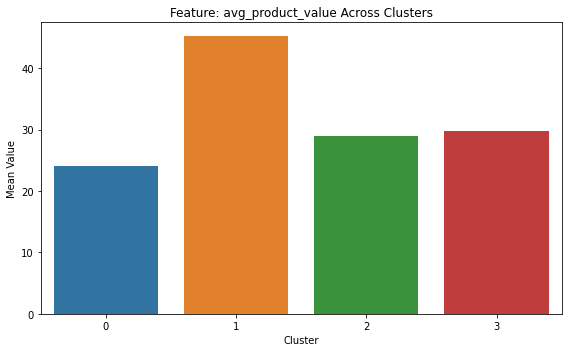

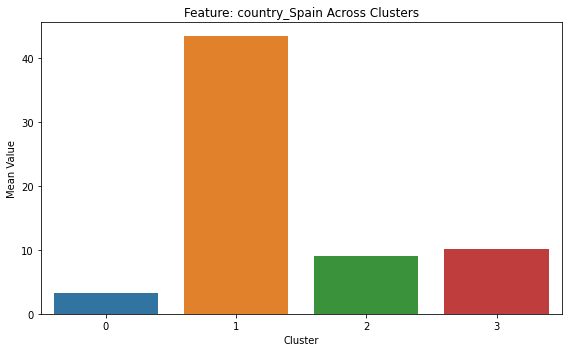

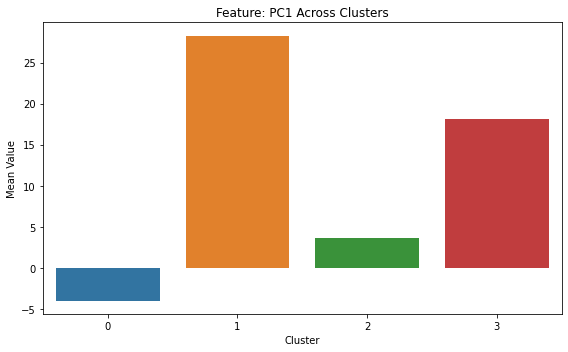

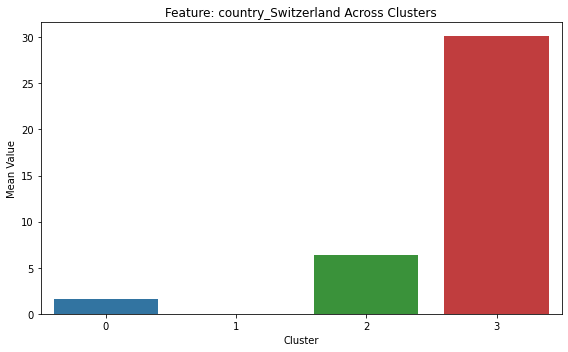

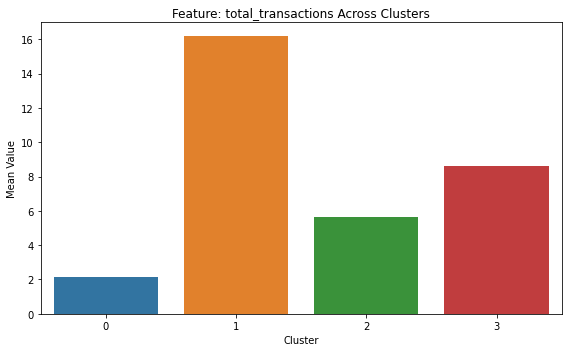

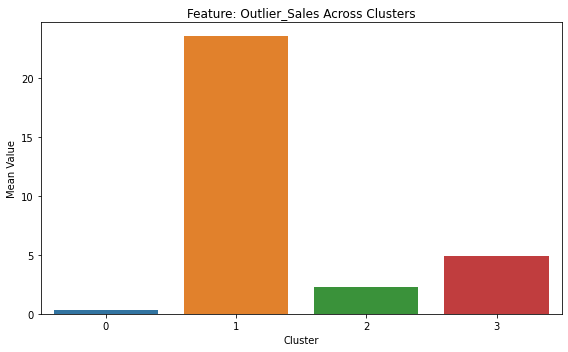

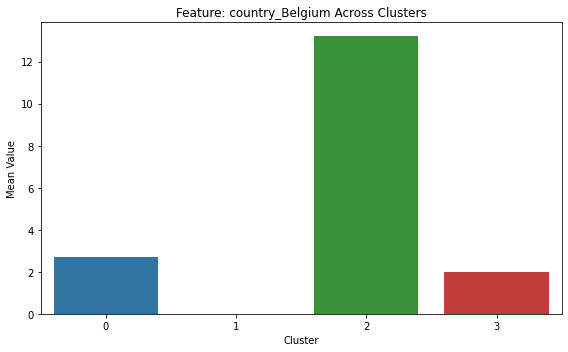

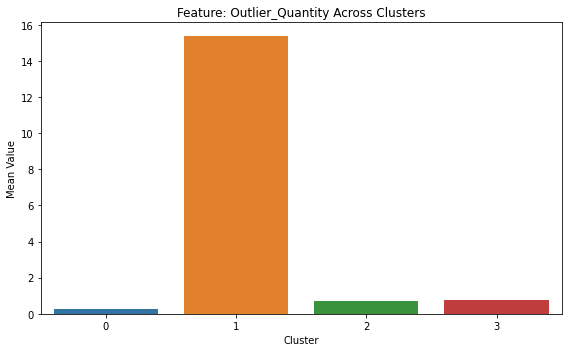

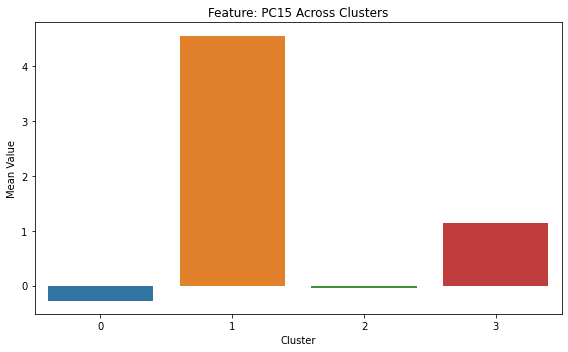

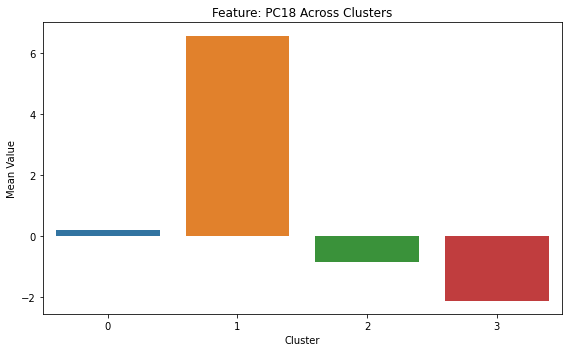

In [36]:
# For top 20 feature analysis
feature_analysis(df_kmean_4_clusters, labels)

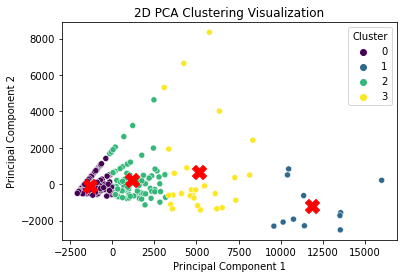

In [37]:
pca_2d_visualization(df_kmean_4_clusters, labels, centroids)

### K-Means Clustering Observations: 4 Clusters

#### 1. **Cluster Sizes and General Interpretation**
   - **Cluster 0 (Size: 285):** 
     - The largest cluster, representing the most common customer behaviors or characteristics.
     
   - **Cluster 1 (Size: 11):**
     - The smallest cluster, likely representing outliers or niche customer segments with unique behaviors.
     
   - **Cluster 2 (Size: 91):**
     - A medium-sized cluster, capturing a variation of customer behaviors.
     
   - **Cluster 3 (Size: 27):**
     - A smaller cluster, representing specific customer segments with distinct behaviors.

#### 2. **Feature Analysis**
   - **Spending and Purchasing Patterns:**
     - Cluster 1 leads in total sales, max cart, avg cart, total products, total unique products, total transactions, and outliers.
     - Following in sequence for max values: Cluster 3, Cluster 2, and then Cluster 0.
     
   - **Geographical Analysis:**
     - Switzerland is predominantly in Cluster 3.
     - Belgium is mostly present in Cluster 2.
     - Other countries (except Switzerland and Belgium) are prominent in Cluster 1.
     
   - **Recency of Purchases:**
     - Most recent purchases are majorly found in Cluster 0.
     
   - **Principal Component Analysis (PCA):**
     - PCA components are tough to interpret. However, some higher values are noted in Cluster 1.
     
#### 3. **Cluster Visualization Analysis**
   - **PC1 Differentiation:**
     - All clusters are better distinguished along the first principal component (PC1).
     
   - **PC2 Differentiation:**
     - Clusters 0 and 2, as well as Cluster 3, are close to each other along the second principal component (PC2). There seems to be a mingling of points from these clusters.
     - Cluster 1 appears a bit spread along PC2 and shows potential outliers.

### K-Means Clustering: 5 Clusters

In [38]:
# For fitting KMeans
n_clusters = labels = centroids = None
n_clusters = 5
df_kmean_5_clusters = joined_df.copy()
labels, centroids = fit_kmeans(df_kmean_5_clusters, n_clusters)

#To save labels to compare later
df_labeled['kmean_5'] = labels

In [39]:
# Showing cluster sizes
labels, centroids = fit_kmeans(df_kmean_5_clusters, n_clusters)
show_cluster_sizes(labels)

Cluster Sizes for 5 clusters:
0    283
1     23
2      5
3     11
4     92
dtype: int64


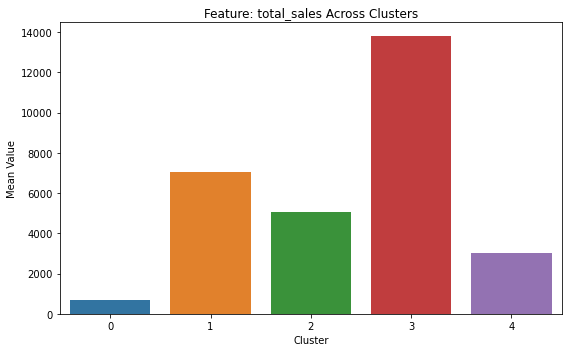

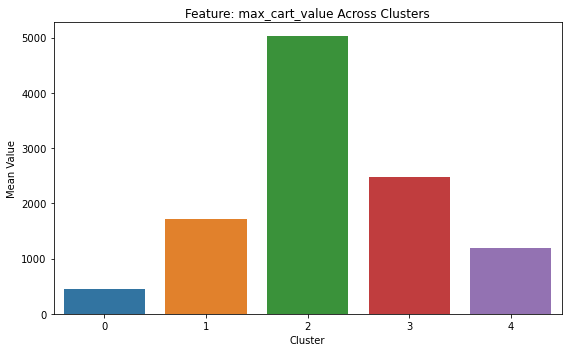

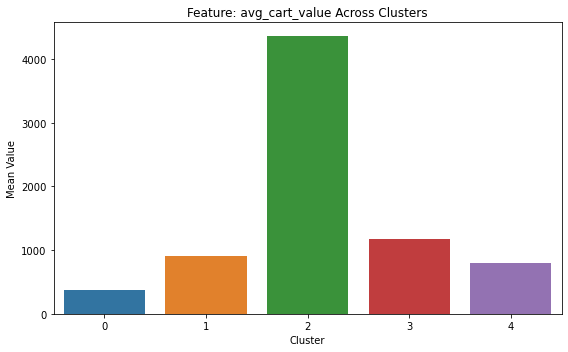

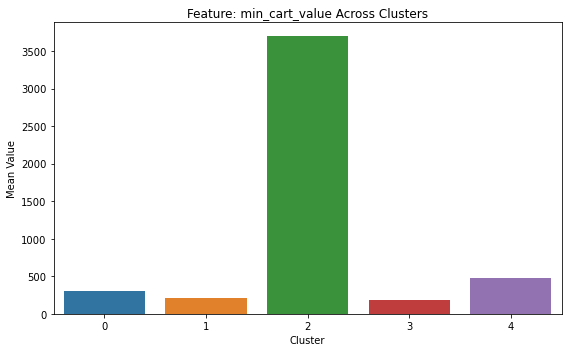

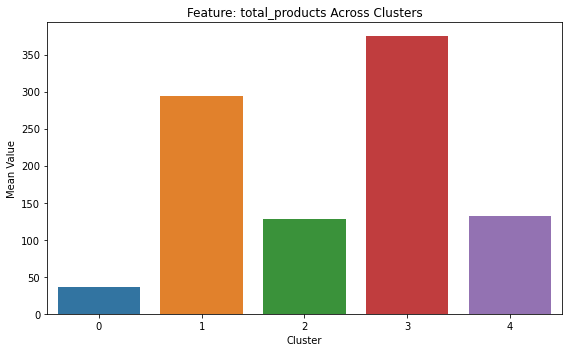

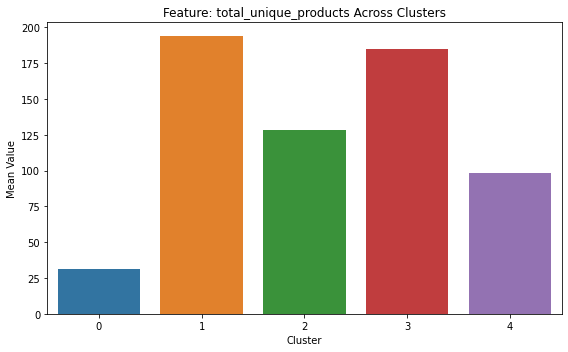

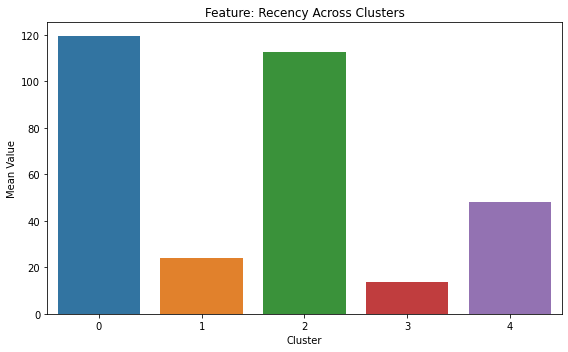

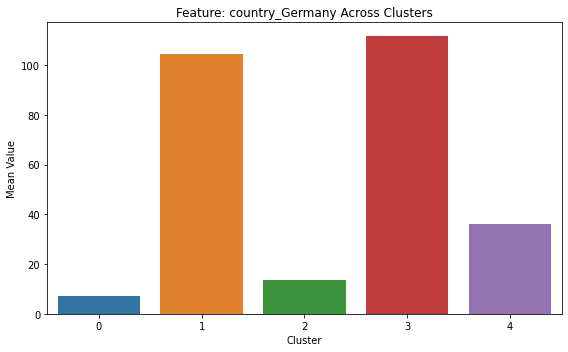

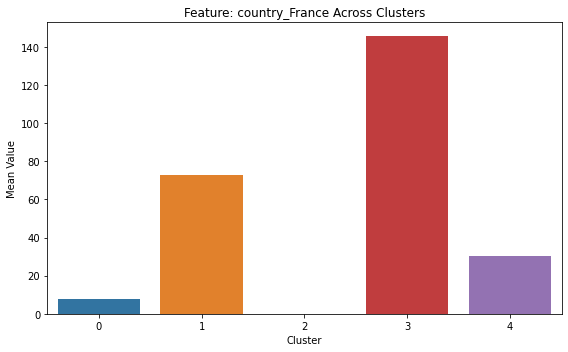

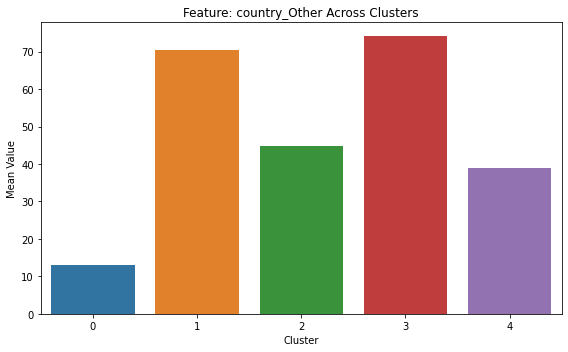

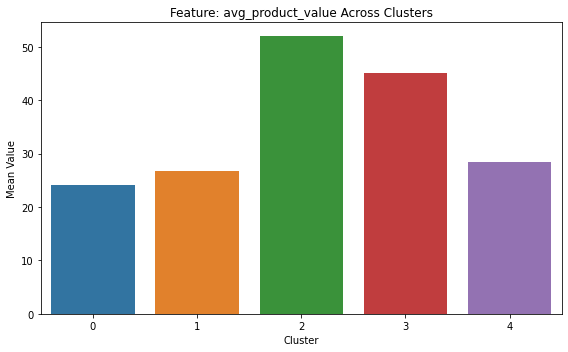

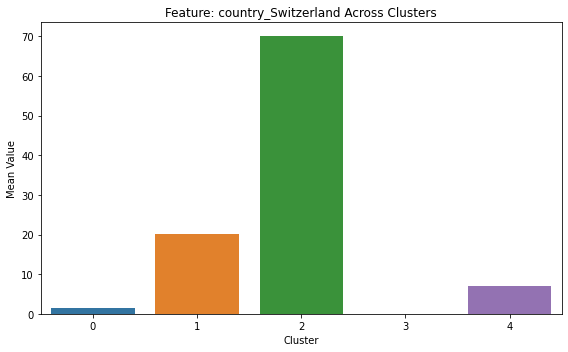

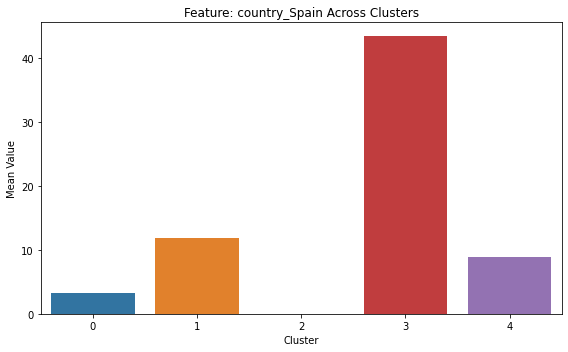

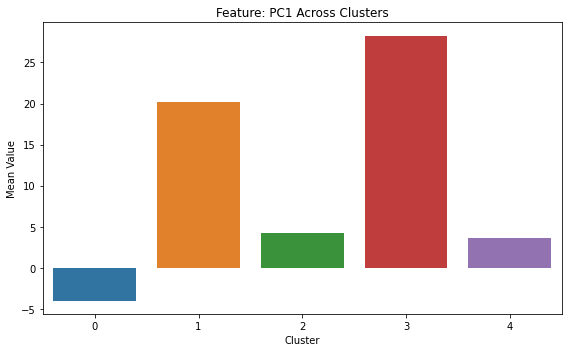

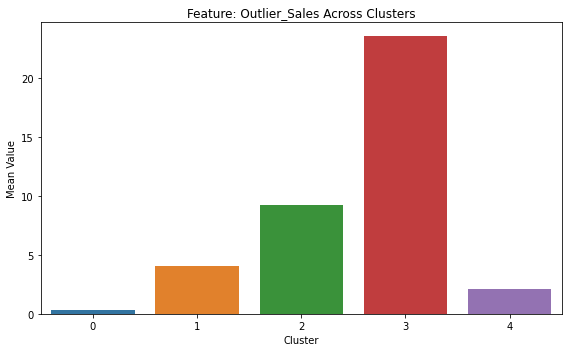

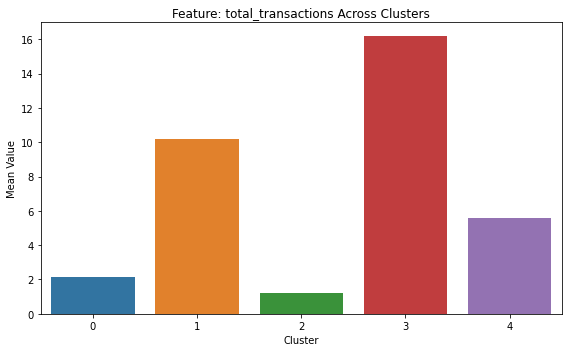

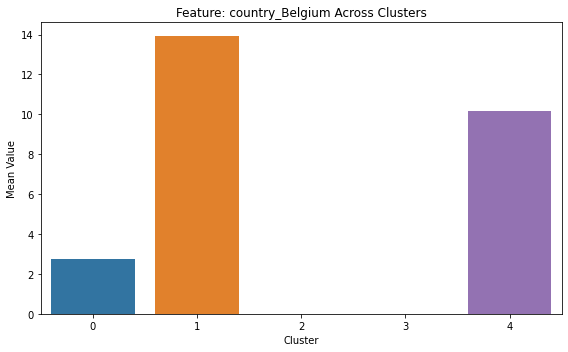

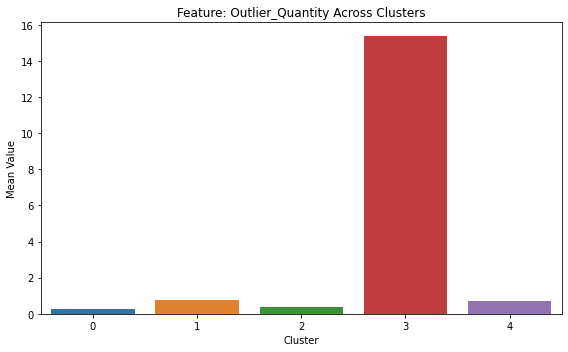

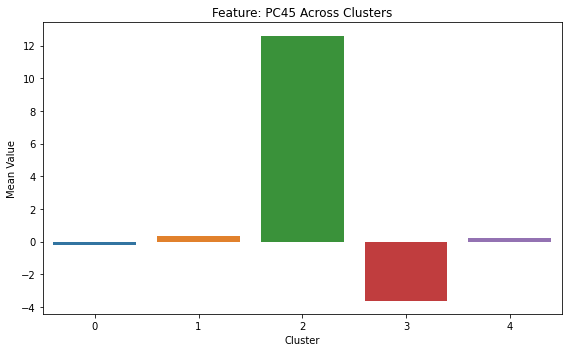

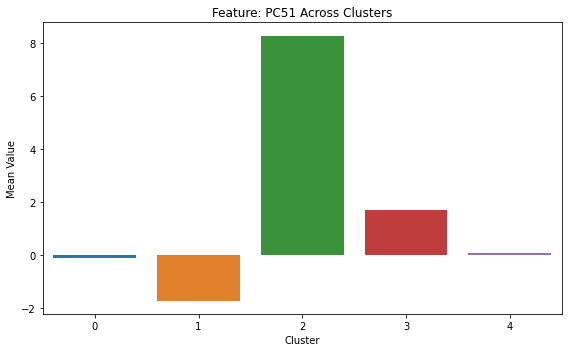

In [40]:
# For top 20 feature analysis
feature_analysis(df_kmean_5_clusters, labels)

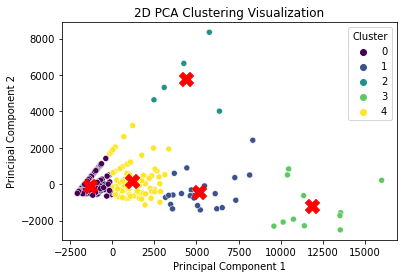

In [41]:
pca_2d_visualization(df_kmean_5_clusters, labels, centroids)

### K-Means Clustering Observations: 5 Clusters

#### 1. **Cluster Sizes and General Interpretation**
   - **Cluster 0 (Size: 283):** 
     - A large cluster representing prevalent customer behaviors or characteristics.
     
   - **Cluster 1 (Size: 23):**
     - A medium-sized cluster indicating a somewhat distinct customer segment.
     
   - **Cluster 2 (Size: 5):**
     - A very small cluster likely representing unique or outlier customer behaviors.
     
   - **Cluster 3 (Size: 11):**
     - A small cluster showing another variation of customer behaviors.
     
   - **Cluster 4 (Size: 92):**
     - A relatively larger cluster capturing a more generalized customer segment.

#### 2. **Feature Analysis**
   - **Spending and Purchasing Patterns:**
     - **Clusters 3 and 1** dominate in total sales, total products, total unique products, and total transactions.
     - **Cluster 2** leads in max cart, avg cart, min cart, and avg product value.
     
   - **Geographical Analysis:**
     - Germany and other countries are mainly represented in **Clusters 1 and 3**.
     - Spain and France are predominantly in **Cluster 3**.
     - Switzerland mostly appears in **Cluster 2**.
     - Belgium is primarily in **Cluster 1**.
     
   - **Recency of Purchases:**
     - Most recent purchases predominantly appear in **Clusters 0 and 2**.
     
   - **Outliers:**
     - Most outliers are situated in **Cluster 3**.
     
   - **Principal Component Analysis (PCA):**
     - Interpretation of some principal components needs further analysis to draw meaningful conclusions.
     
#### 3. **Cluster Visualization Analysis**
   - **Improved Segmentation:**
     - With five clusters, there’s better separation and denseness observed in both principal components (PC1 and PC2), revealing more refined customer segments.
     - The five-cluster solution unveils subtleties within the customer base, leading to a more nuanced understanding of customer behaviors.

<hr style="border: none; border-top: 3px solid black;">

### Summary from K-Means Clustering Experiments (3, 4, and 5 Clusters)

#### Overview

Three different K-Means clustering experiments were conducted with 3, 4, and 5 clusters, to explore the ideal segmentation of customers based on various features such as spending patterns, geographical locations, recency of purchases, and PCA components.

#### Observations

##### 1. **Cluster Sizes:**
   - The size of the clusters varied with the number of clusters chosen. As expected, increasing the number of clusters led to smaller, more nuanced segments.
   - Smaller clusters seem to capture unique or outlier customer behaviors, while larger clusters encapsulate more common customer behaviors.

##### 2. **Spending Patterns:**
   - Clusters in all experiments showed variations in spending patterns, total transactions, and product purchases.
   - Notable differences were observed in maximum, minimum, and average cart values across clusters.

##### 3. **Geographical Distribution:**
   - Different clusters seem to resonate more with customers from certain countries. There was a variable country representation across clusters in each experiment.

##### 4. **Recency of Purchases:**
   - Variations were observed in the recency of purchases across clusters, indicating different levels of customer engagement.

##### 5. **Principal Component Analysis (PCA):**
   - PCA components required further interpretation in all cases.
   - The experiments showed variations in PCA component influences and their distinctions in clustering.

##### 6. **Cluster Visualization:**
   - Visualization clarity improved with an increase in the number of clusters, leading to better-separated and more defined customer groups.

#### Summary

- **3-Cluster Experiment:**
   - Provided a broad overview and was more generalized in capturing customer behaviors.
   
- **4-Cluster Experiment:**
   - Brought in more granularity in customer segmentation, allowing for the identification of more specific behaviors and characteristics.
   
- **5-Cluster Experiment:**
   - Further refined the customer segments, unveiling nuanced behaviors and providing a more detailed perspective of customer variations.

#### Conclusive Guidance

- **Experiment with More Clusters:**
   - It could be beneficial to experiment further by increasing the number of clusters to continue unveiling more nuanced customer segments.

- **Detailed PCA Interpretation:**
   - A deep dive into the PCA components can provide more clarity and improve the effectiveness of clustering.

- **Geographical Exploration:**
   - Further exploring geographical representations could provide more insights into regional customer behaviors and preferences.

- **Customizing Marketing Strategies:**
   - The insights gathered could be instrumental in customizing marketing strategies to target specific customer segments effectively.


# Hierarchical Clustering:

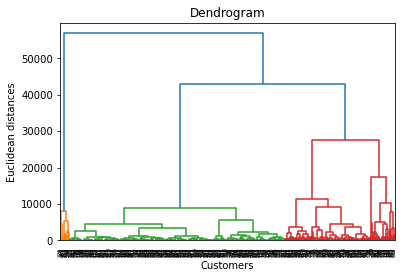

In [42]:
# Creating the dendrogram
X_hc = joined_df.copy()
dendrogram = sch.dendrogram(sch.linkage(X_hc, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()


### Clustering Observations

- **dendrogram Analysis:**
  - There is a posibility of 3, 4 or 5 clusters to be created, will try all

### Hierarchical: 3 Clusters

In [43]:
n_clusters = X_hc = labels = visual_df = None
X_hc = joined_df.copy()
n_clusters = 3

# Perform clustering
labels = hierarchical_clustering(X_hc, n_clusters)

#To save labels to compare later
df_labeled['hc_3'] = labels

# Print cluster sizes
show_cluster_sizes(labels)

Silhouette Score for 3 Clusters: 0.5456061071080882
Cluster Sizes for 3 clusters:
0    136
1     11
2    267
dtype: int64


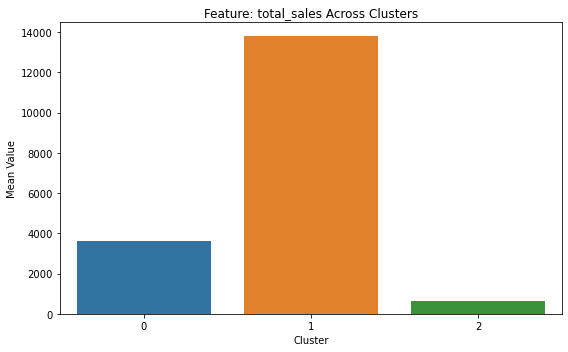

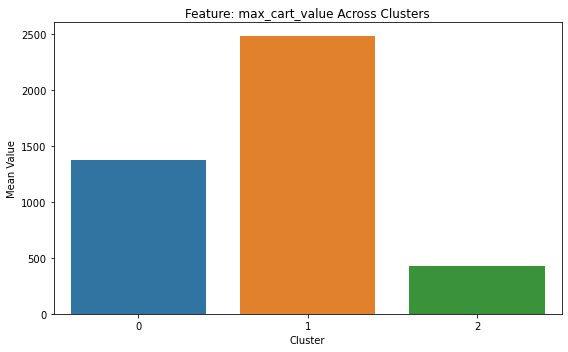

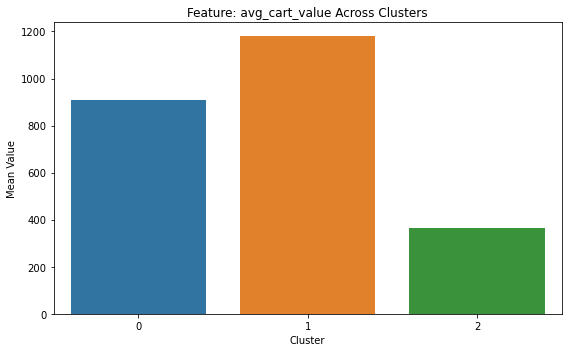

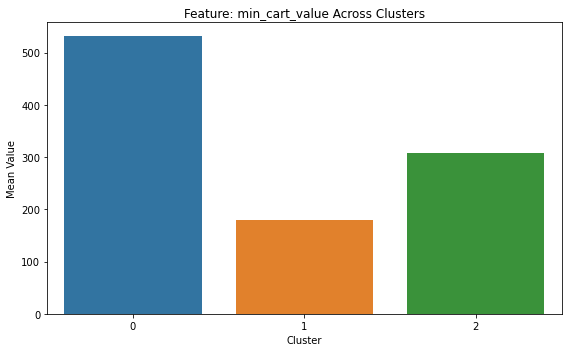

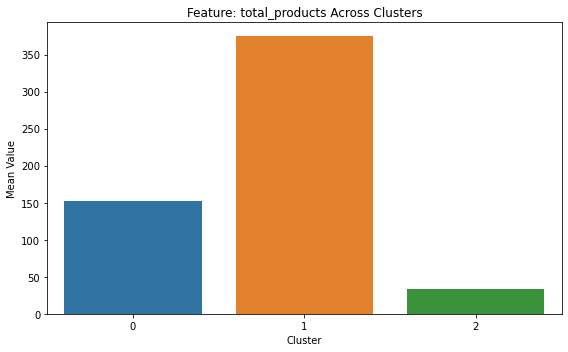

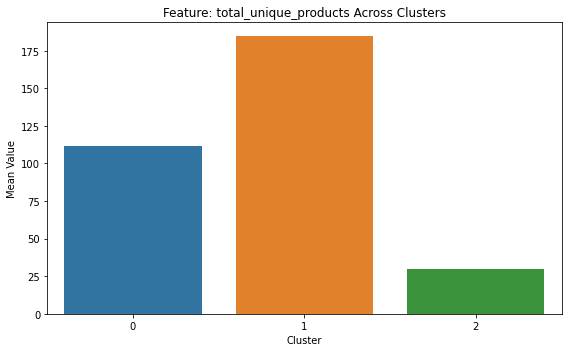

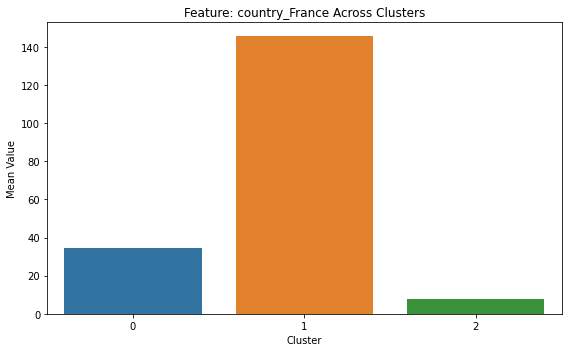

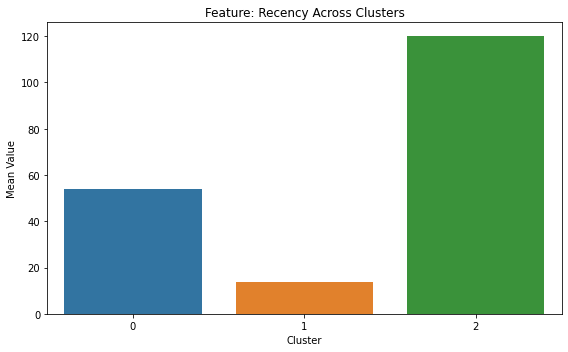

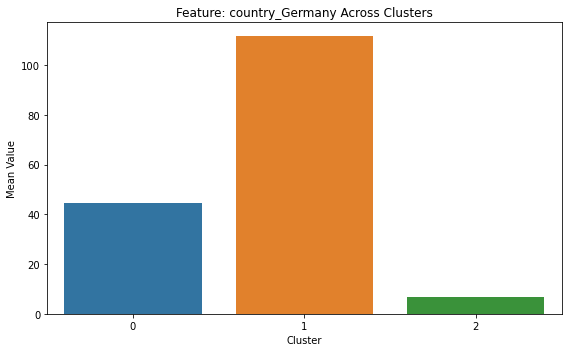

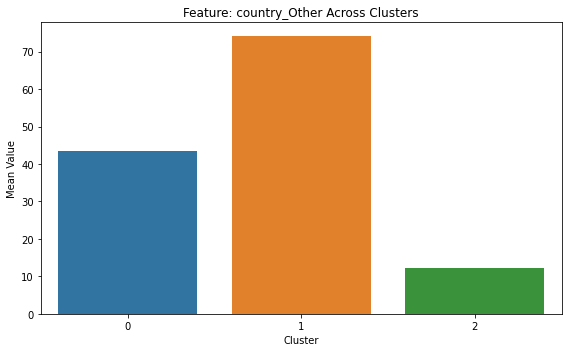

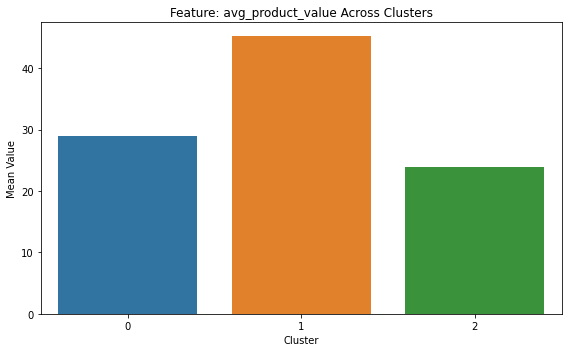

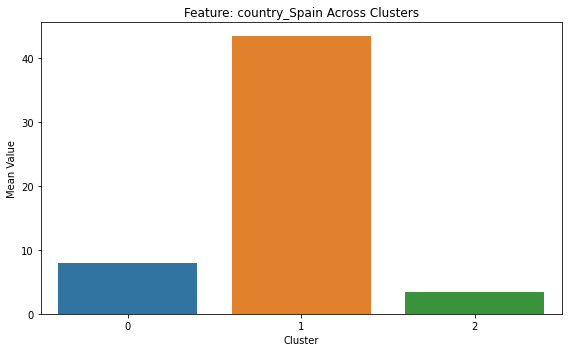

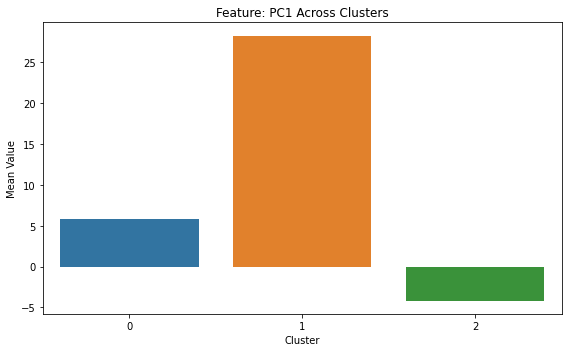

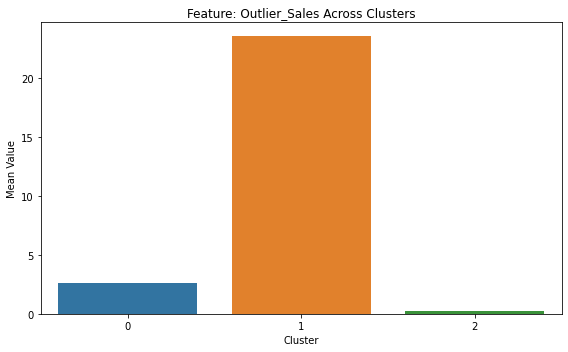

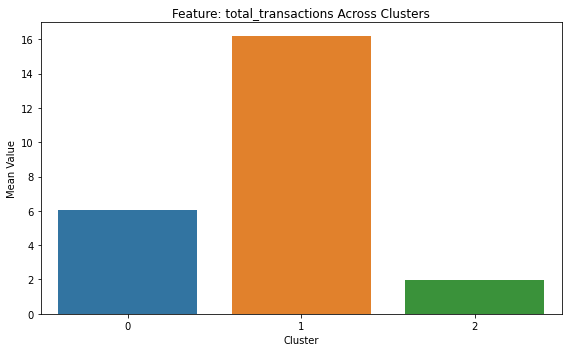

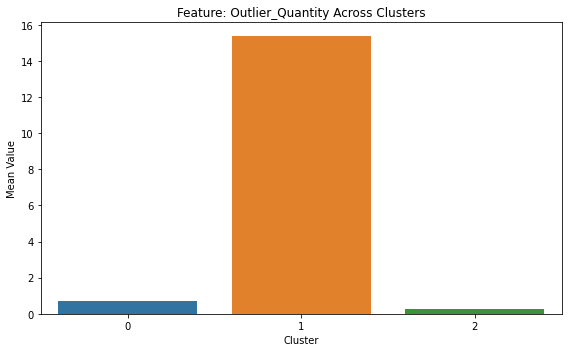

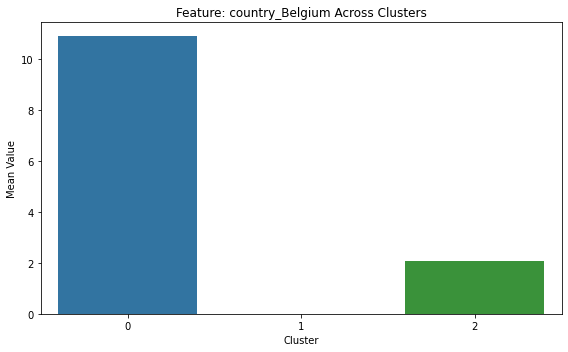

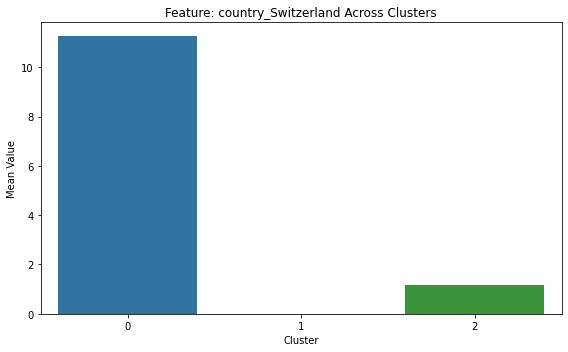

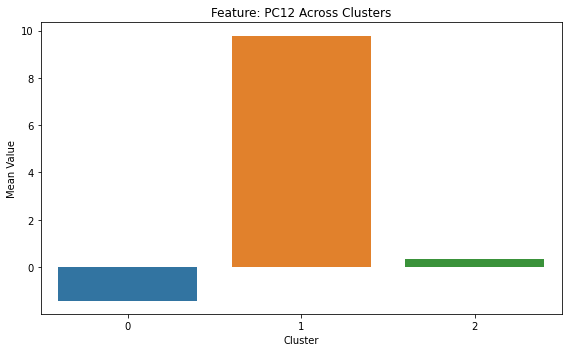

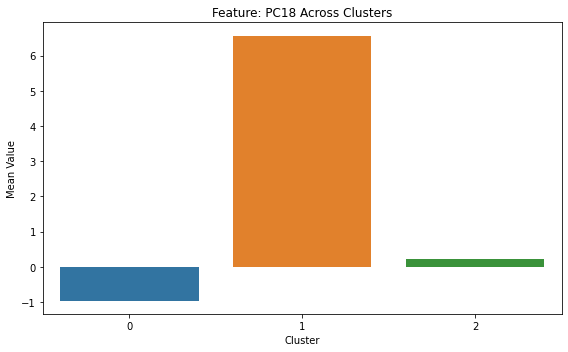

In [44]:
# For top 20 feature analysis
feature_analysis(X_hc, labels)

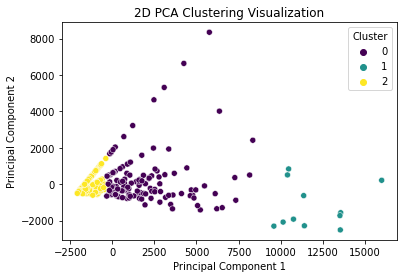

In [45]:
# PCA and visualization
pca_2d_visualization(X_hc, labels)

### Hierarchical Clustering Analysis with 3 Clusters

#### Silhouette Score:
- The silhouette score for the 3-cluster solution is `0.5456`, indicating moderate separation between the clusters.

#### Cluster Sizes:
- **Cluster 0:** 136
- **Cluster 1:** 11
- **Cluster 2:** 267

#### General Interpretation of Cluster Sizes:
- The distribution of sizes suggests that Cluster 2 captures the majority of customers, possibly representing the general customer base.
- Cluster 1, while the smallest, seems to consist of high-value customers due to its high sales and product numbers.
- Cluster 0 has a moderate size, which might indicate a mix of sporadic and regular customers.

#### Feature Analysis:
1. **Sales and Products:**
   - **Top cluster for sales metrics:** Cluster 1
     - **Interpretation:** Represents a segment of customers with higher purchasing activity, indicating high-value customers.
   
2. **Recency:**
   - **Top cluster for recent activity:** Cluster 2
     - **Interpretation:** This could be a segment of recently acquired customers or those with regular purchasing habits.

3. **Geographical Distribution:**
   - **Top cluster in France, Germany, Spain, other countries:** Cluster 1
   - **Top cluster in Belgium, Switzerland:** Cluster 0
     - **Interpretation:** Indicates differing geographic market segments, with Cluster 1 being more international.

4. **Outliers:**
   - **Top cluster with outliers:** Cluster 1
     - **Interpretation:** Signifies customers with atypical purchasing patterns, which could be either very high-value or infrequent large purchases.

5. **Principal Components Analysis (PCA):**
   - Clusters 1 and 2 are distinct along PC1 and PC2.
   - **Interpretation:** Supports the existence of distinct customer segments, with Cluster 1 being particularly differentiated.

6. **Visualization:**
   - Clusters 1 and 2 show clear separation in PCA visualization.
   - Cluster 0 is more dispersed, indicating within-cluster variability and potential outliers.

#### Interpretation and Strategy Recommendations:
- **Customer Engagement:** Engage with Cluster 2 customers to maintain their recent activity levels and further analyze Cluster 1 to tailor services for high-value customers.
- **Tailored Marketing:** Develop international marketing strategies for Cluster 1 and region-specific campaigns for Cluster 0.
- **Outlier Management:** Investigate Cluster 1 outliers for risk management and to potentially identify niche market opportunities.

#### Notes:
- Cluster 1, despite its small size, shows significant purchasing activity, suggesting a focused approach for retention and growth could be beneficial.
- The large size of Cluster 2 could indicate a diverse customer base, ideal for broad marketing strategies.


### Hierarchical: 4 Clusters

In [46]:
n_clusters = X_hc = labels = visual_df = None
X_hc = joined_df.copy()
n_clusters = 4

# Perform clustering
labels = hierarchical_clustering(X_hc, n_clusters) 

#To save labels to compare later
df_labeled['hc_4'] = labels

# Print cluster sizes
show_cluster_sizes(labels)

Silhouette Score for 4 Clusters: 0.5460492375090384
Cluster Sizes for 4 clusters:
0     31
1    105
2    267
3     11
dtype: int64


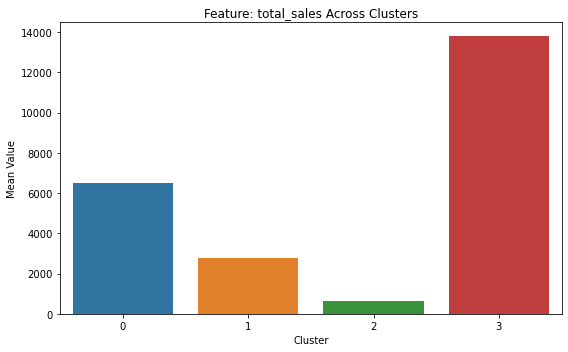

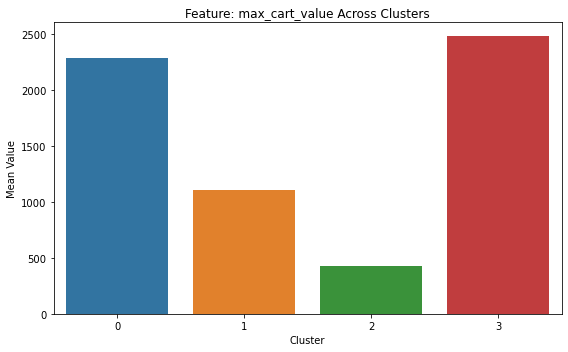

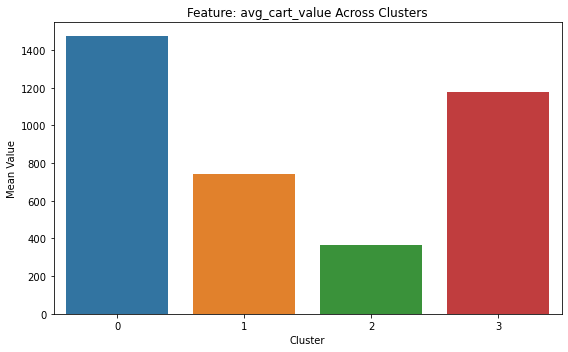

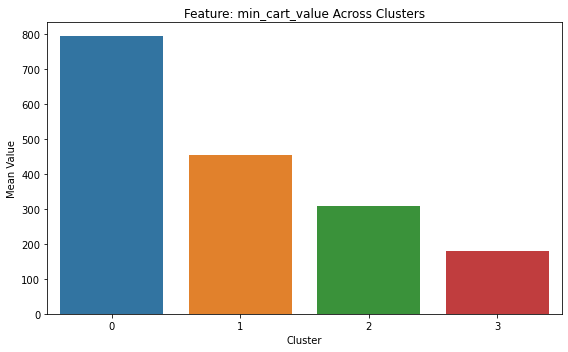

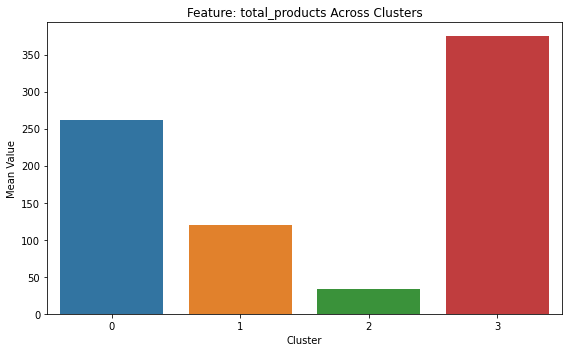

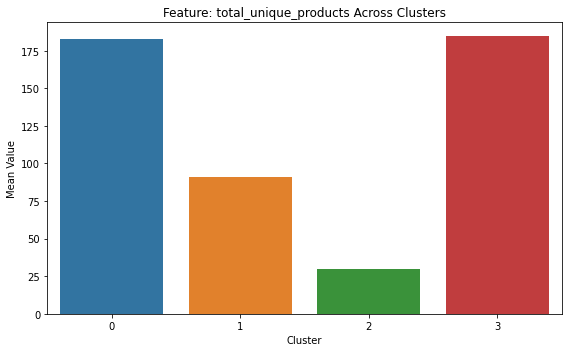

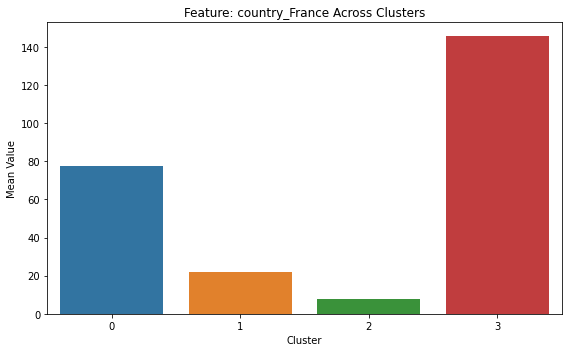

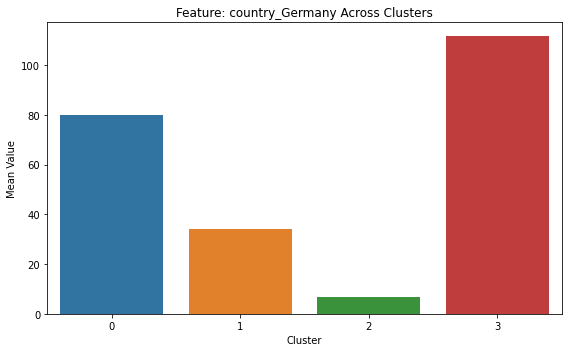

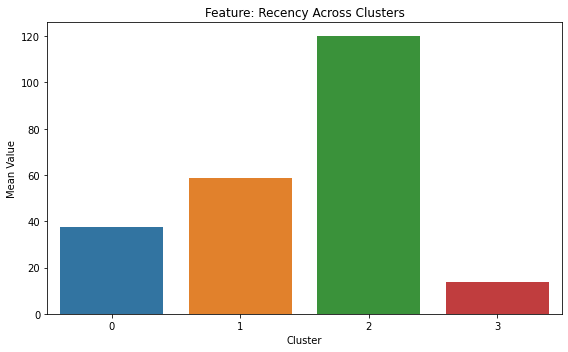

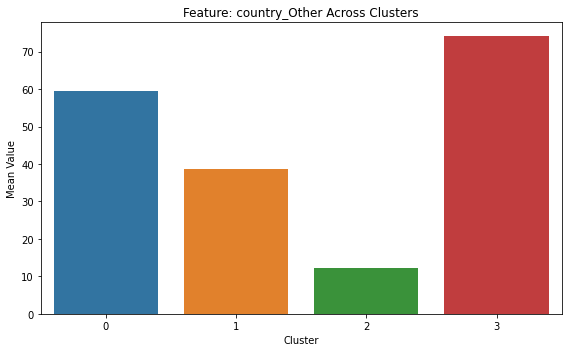

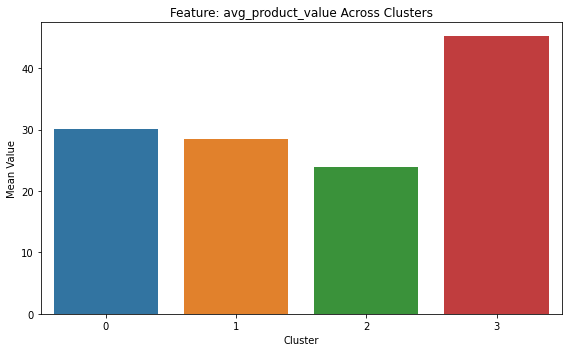

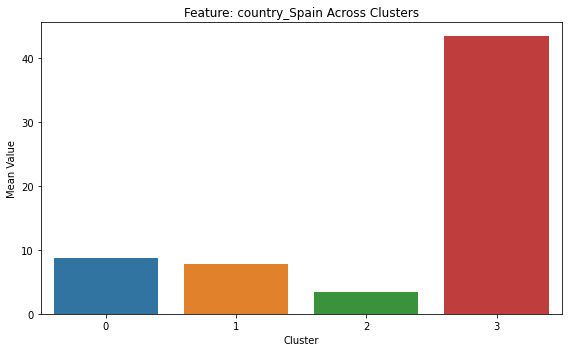

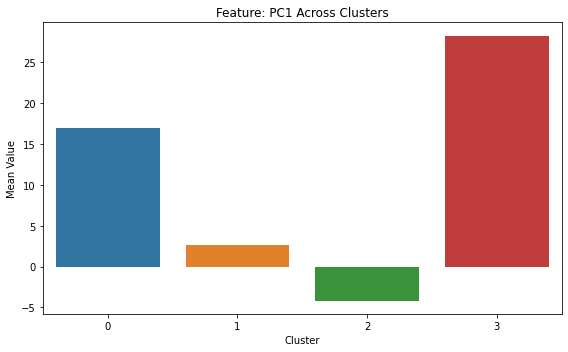

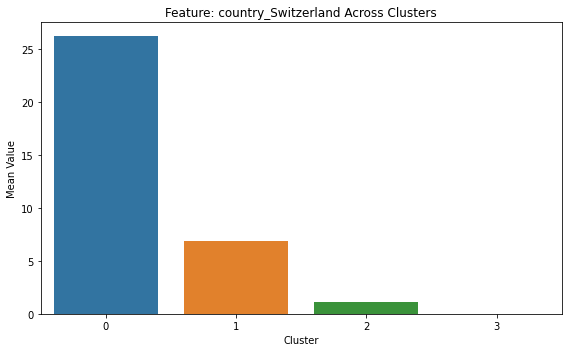

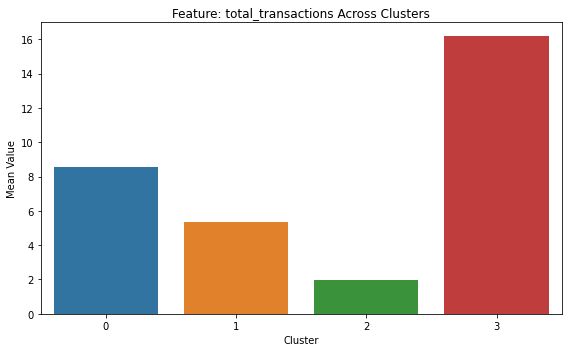

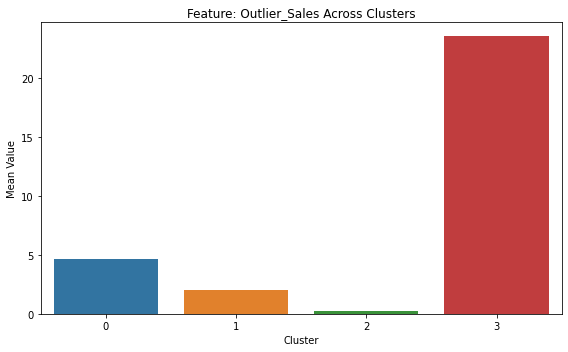

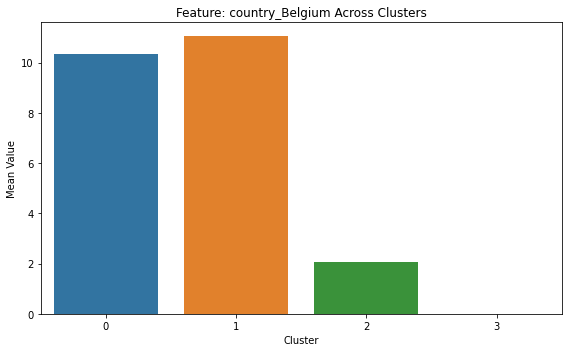

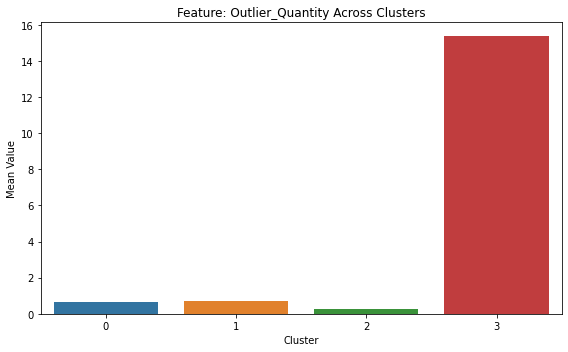

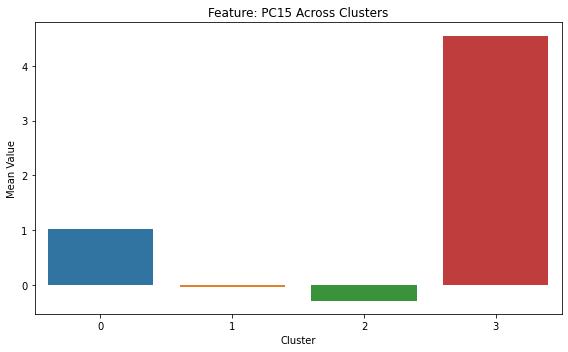

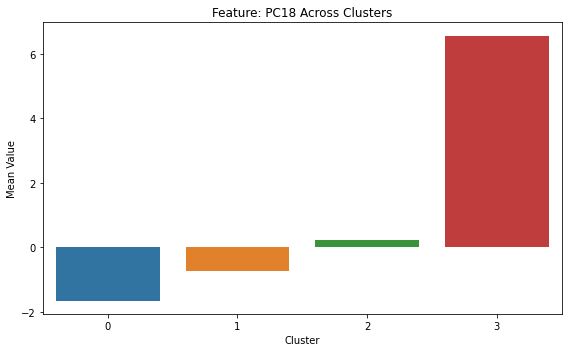

In [47]:
# For top 20 feature analysis
feature_analysis(X_hc, labels)

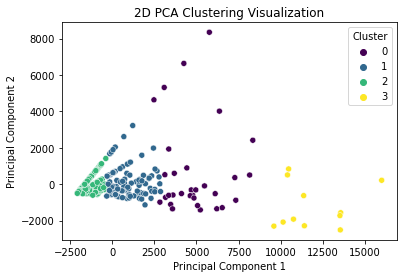

In [48]:
# PCA and visualization
pca_2d_visualization(X_hc, labels)

### Hierarchical Clustering Analysis with 4 Clusters

#### Silhouette Score:
- The silhouette score for the 4-cluster solution is `0.5460`, suggesting a moderate distinction between the clusters.

#### Cluster Sizes:
- **Cluster 0:** 31
- **Cluster 1:** 105
- **Cluster 2:** 267
- **Cluster 3:** 11

#### General Interpretation of Cluster Sizes:
- The distribution suggests Cluster 2 is the largest, likely indicative of the average customer.
- Clusters 0 and 3 are smaller, possibly denoting niche segments with distinct purchasing behaviors.

#### Feature Analysis:
1. **Sales Metrics:**
   - **Top cluster for total sales and product metrics:** Cluster 3
     - **Interpretation:** Likely represents high-value customers with significant purchasing power.

2. **Cart Analysis:**
   - **Top cluster for cart value metrics:** Cluster 0
     - **Interpretation:** May represent a segment that makes fewer, but more valuable purchases.

3. **Recency:**
   - **Top cluster for recent activity:** Cluster 2
     - **Interpretation:** Suggests a segment of new or consistently active customers.

4. **Geographical Distribution:**
   - **Top cluster in France, Germany, Spain, other countries:** Cluster 1
   - **Top clusters in Belgium, Switzerland:** Cluster 0
     - **Interpretation:** Reflects how different clusters engage with specific markets.

5. **Outliers:**
   - **Top cluster with outliers:** Cluster 3
     - **Interpretation:** Contains customers with atypical behavior which could be strategic targets for personalized marketing.

6. **Principal Components Analysis (PCA):**
   - Clusters 1, 2, and 3 are well-distinguished along both principal components.
   - **Interpretation:** Implies distinct customer behaviors that can be leveraged for targeted strategies.

7. **Visualization:**
   - Clusters 1, 2, and 3 show clear separation on the PCA plot.
   - Cluster 0 is more scattered, suggesting a diverse set of behaviors within this group.

#### Interpretation and Strategy Recommendations:
- **Targeted Engagement:** Given Cluster 3's high metrics, personalized engagement strategies could lead to further growth.
- **Selective Marketing:** Tailor marketing to the unique needs of the smaller, more distinct customer bases of Clusters 0 and 3.
- **Customer Retention:** With Cluster 2 representing a large portion of customers, retention strategies should be prioritized.
- **Market Penetration:** Use the geographic preferences of Clusters 1 and 0 to guide regional marketing strategies.

##### Notes:
- The presence of a small but significant cluster like Cluster 3 can indicate a high potential for ROI with targeted initiatives.
- The variability within Cluster 0 suggests the need for deeper analysis to understand the diverse customer needs within this segment.


### Hierarchical: 5 Clusters

In [49]:
n_clusters = X_hc = labels = visual_df = None
X_hc = joined_df.copy()
n_clusters = 5

print(f"\nAnalyzing {n_clusters} clusters:")

# Perform clustering
labels = hierarchical_clustering(X_hc, n_clusters) 

#To save labels to compare later
df_labeled['hc_5'] = labels

# Print cluster sizes
show_cluster_sizes(labels)


Analyzing 5 clusters:
Silhouette Score for 5 Clusters: 0.5563130274575813
Cluster Sizes for 5 clusters:
0    105
1     27
2    267
3     11
4      4
dtype: int64


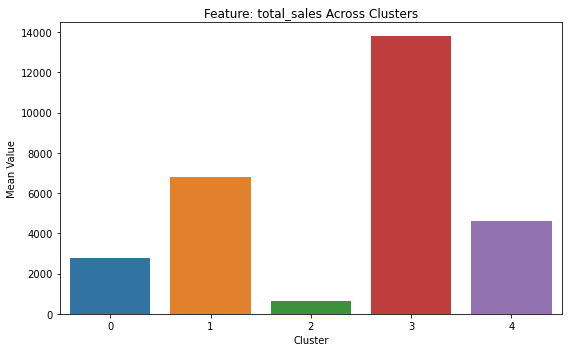

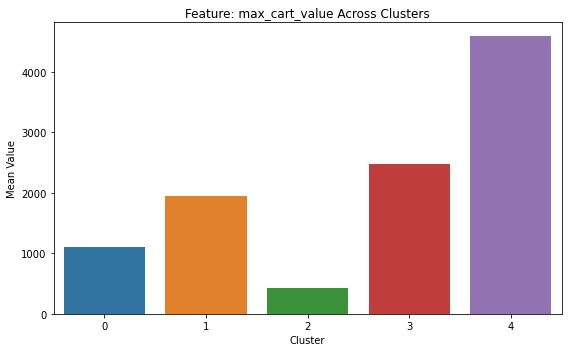

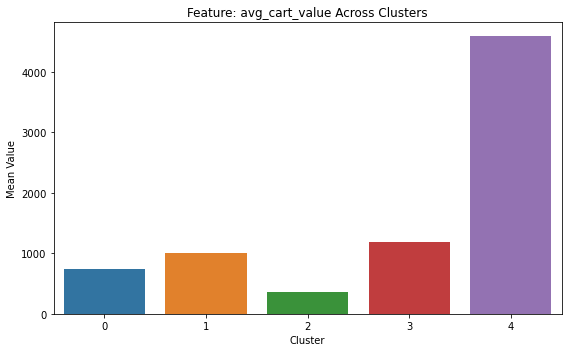

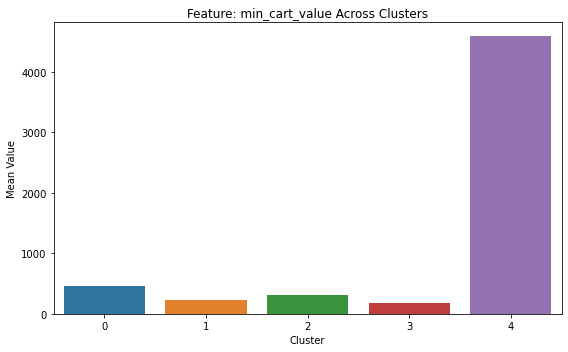

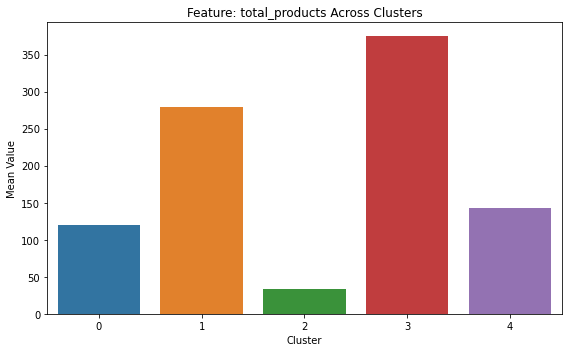

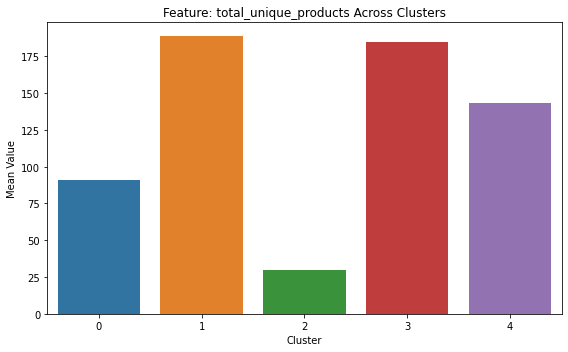

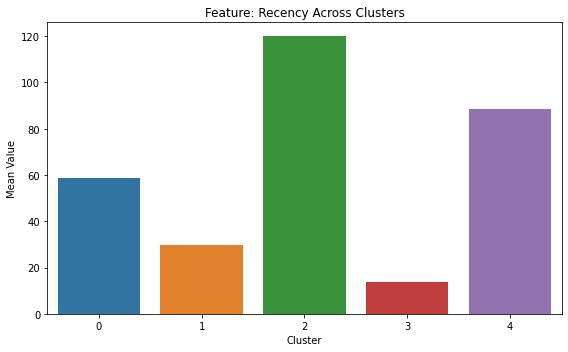

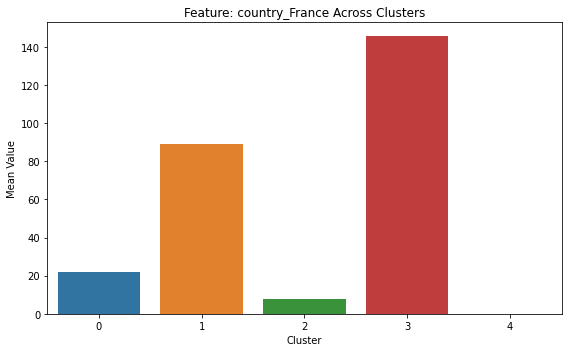

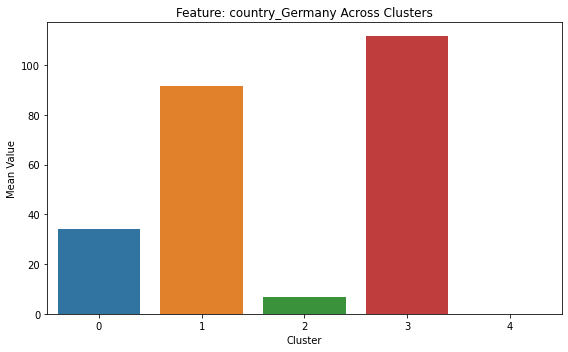

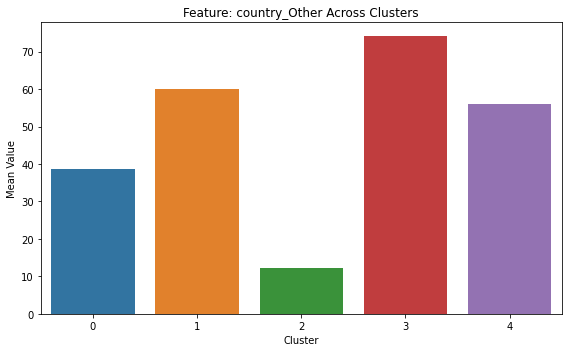

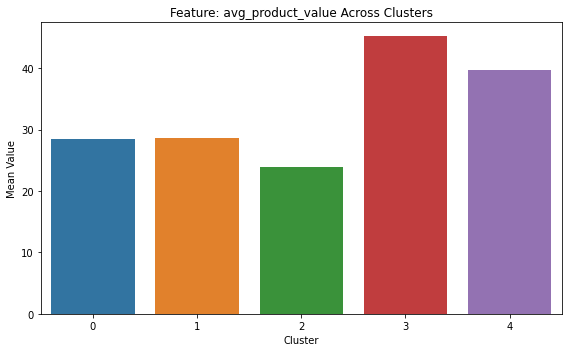

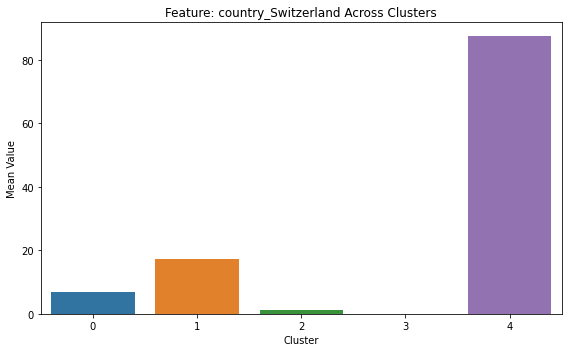

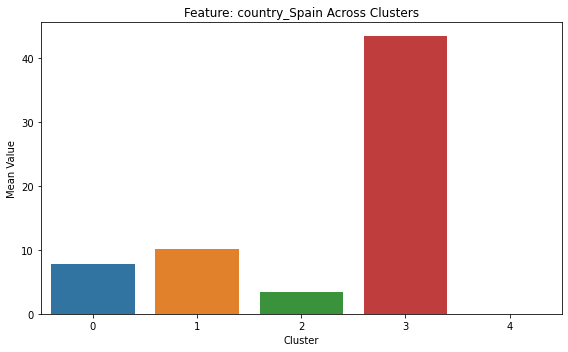

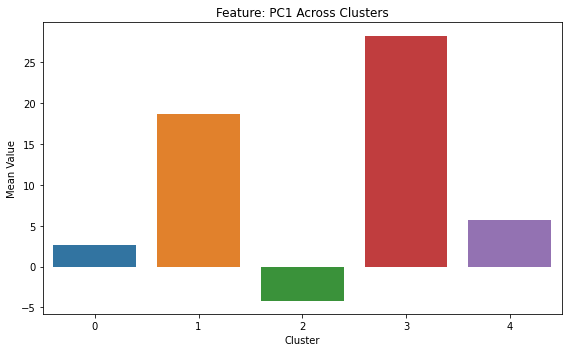

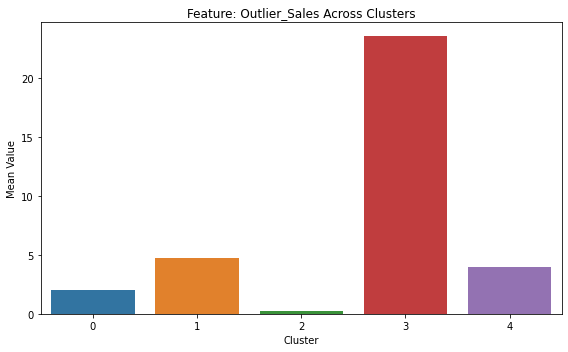

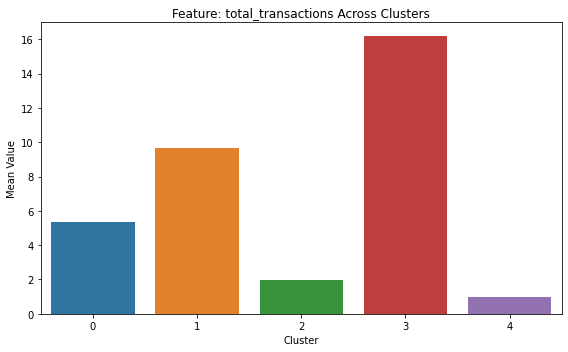

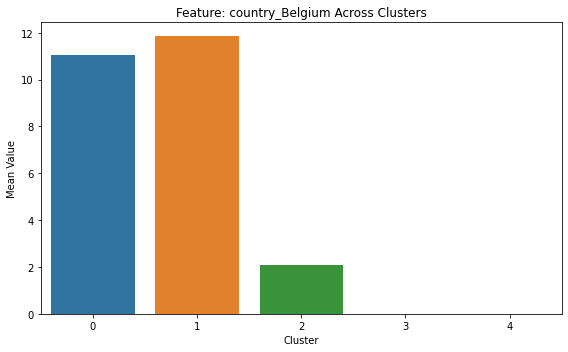

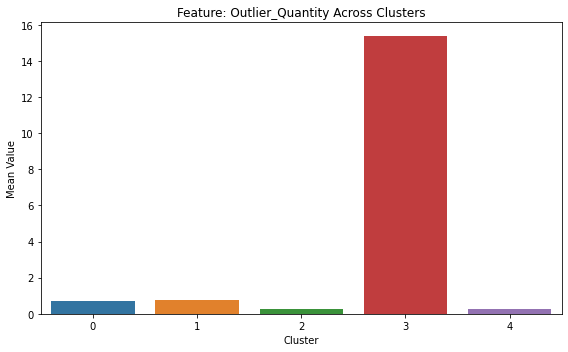

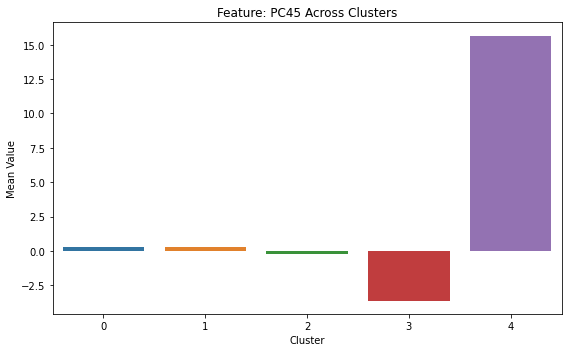

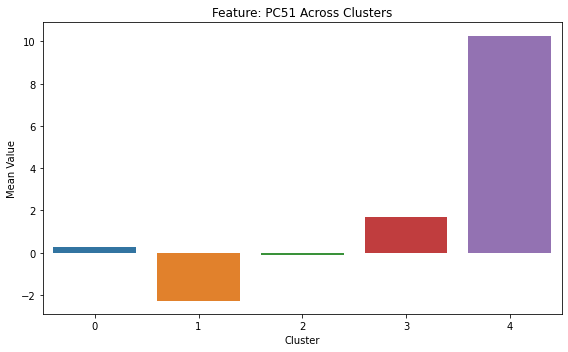

In [50]:
# For top 20 feature analysis
feature_analysis(X_hc, labels)

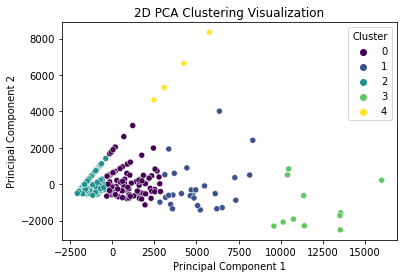

In [51]:
# PCA and visualization
pca_2d_visualization(X_hc, labels)

### Hierarchical Clustering Analysis with 5 Clusters

#### Silhouette Score:
- The silhouette score for the 5-cluster solution is `0.5563`, indicating slightly improved cluster separation compared to the 4-cluster model.

#### Cluster Sizes:
- **Cluster 0:** 105
- **Cluster 1:** 27
- **Cluster 2:** 267
- **Cluster 3:** 11
- **Cluster 4:** 4

#### General Interpretation of Cluster Sizes:
- The cluster sizes suggest that Cluster 2 is the predominant group, whereas Cluster 4 is very exclusive, possibly representing an ultra-niche customer segment.

#### Feature Analysis:
1. **Sales Metrics:**
   - **Top cluster for sales metrics:** Cluster 3, followed by Cluster 1
     - **Interpretation:** Cluster 3 potentially signifies a small group of customers driving significant revenue, warranting special attention.

2. **Cart Value Analysis:**
   - **Top cluster for cart value metrics:** Cluster 4
     - **Interpretation:** Despite its small size, Cluster 4’s high cart values indicate highly valuable purchasing patterns.

3. **Recency:**
   - **Top cluster for recent activity:** Cluster 2
     - **Interpretation:** Indicates these customers are currently the most active or recent shoppers.

4. **Geographic Distribution:**
   - **Clusters leading in Germany, Spain, France, and other countries:** 1 and 3
   - **Cluster leading in Switzerland:** 4
   - **Clusters leading in Belgium:** 1 and 0
     - **Interpretation:** Provides insights into the geographic preferences and market potential for each cluster.

5. **Outliers:**
   - **Cluster with significant outliers:** Cluster 3
     - **Interpretation:** Outlier analysis might reveal unique customer needs or opportunities for upselling.

6. **Principal Components Analysis (PCA):**
   - PCA interpretation requires more analysis, particularly for some principal components.
     - **Interpretation:** Further investigation could uncover more nuanced behaviors and characteristics within clusters.

7. **Visualization:**
   - A 5-cluster solution has resulted in better-defined groupings, with separation and denseness clearly visible in the PCA plot.
     - **Interpretation:** This finer segmentation aids in understanding diverse customer behaviors and could inform more tailored strategies.

#### Interpretation and Strategy Recommendations:
- **Cluster 3 Engagement:** Due to its impact on sales, creating customized experiences for Cluster 3 could yield high returns.
- **Cluster 4 Strategy:** Investigate the unique characteristics of Cluster 4 to exploit this high-value segment effectively.
- **Activity Retention:** With Cluster 2 being the most active, focus on engagement and retention could solidify a stable customer base.
- **Geographical Focus:** Clusters 1 and 3’s geographic distribution should shape international marketing strategies.

##### Notes:
- The distinct nature of Cluster 4, despite its small size, could represent a premium segment with specific preferences or purchasing power.
- The larger clusters, such as Cluster 2, reinforce the need for broad-reaching retention strategies, while smaller clusters suggest personalized marketing approaches.


<hr style="border: none; border-top: 3px solid black;">

### Consolidated Summary of Hierarchical Clustering Analysis

#### Hierarchical Clustering Analysis with 5 Clusters
- **Silhouette Score:** 0.5563
- **Cluster Sizes:** Cluster 0: 105, Cluster 1: 27, Cluster 2: 267, Cluster 3: 11, Cluster 4: 4
- **General Observations:** 
  - Cluster 2 is the largest, while Cluster 4 is very exclusive.
  - Cluster 3 has significant sales metrics; Cluster 4 has high cart values.
  - Recency is highest in Cluster 2, indicating recent activity.
  - Geographical distribution varies, with Clusters 1 and 3 leading in several countries.
  - Cluster 3 contains significant outliers.
  - Improved cluster definition in visualization, indicating refined customer segments.

#### Hierarchical Clustering Analysis with 4 Clusters
- **Silhouette Score:** 0.5460
- **Cluster Sizes:** Cluster 0: 31, Cluster 1: 105, Cluster 2: 267, Cluster 3: 11
- **General Observations:** 
  - Cluster 2 remains the largest; Cluster 3 indicates high-value customers.
  - Cluster 0 shows high cart values, perhaps indicating premium purchases.
  - Clusters 1, 2, and 3 are well-distinguished in the PCA plot.
  - Geographical preferences suggest regional market penetration strategies.

#### Hierarchical Clustering Analysis with 3 Clusters
- **Silhouette Score:** 0.5456
- **Cluster Sizes:** Cluster 0: 136, Cluster 1: 11, Cluster 2: 267
- **General Observations:** 
  - Cluster 2 captures the general customer base.
  - Cluster 1, though smallest, has high sales metrics, suggesting high-value customers.
  - The PCA plot shows Clusters 1 and 2 with clear separation.
  - Diverse geographic market segments with Cluster 1 being more international.

#### Overall Strategy Recommendations Across Cluster Models:
1. **Engage High-Value Segments:** Focus on Cluster 3 in the 5 and 4 cluster solutions and Cluster 1 in the 3 cluster solution for customized experiences due to their significant impact on sales.
2. **Retention and Engagement:** Prioritize customer retention for the large customer base in Cluster 2 across all models.
3. **Geographic Tailoring:** Leverage geographic insights from each cluster analysis to create region-specific marketing strategies.
4. **Manage Outliers:** Investigate outliers, particularly in Cluster 3 in the 5 and 4 cluster solutions and Cluster 1 in the 3 cluster solution, to understand unique customer needs or risks.
5. **PCA Insights:** Further analyze PCA results to differentiate subtle customer behaviors within each cluster.
6. **Segment-Specific Strategies:** Develop targeted strategies for the unique characteristics of the smaller clusters, such as Cluster 4 in the 5 cluster solution and Cluster 0 in the 4 cluster solution.

#### Notes:
- While the larger clusters suggest the need for broad strategies, the smaller, more distinct clusters offer opportunities for highly personalized marketing and engagement approaches.
- The silhouette scores are relatively similar across the three scenarios, which implies stable cluster structures.
- Visualization aids in discerning the effectiveness of the clustering, with higher cluster solutions providing more nuanced customer segmentation.


# DBSCAN 

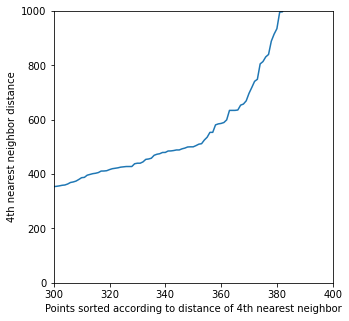

In [52]:
X_dbscan = joined_df.copy()

# Find the nearest neighbors
nearest_neighbors = NearestNeighbors(n_neighbors=4)
neighbors = nearest_neighbors.fit(X_dbscan)
distances, indices = neighbors.kneighbors(X_dbscan)

# Sort distances
distances = np.sort(distances[:,3], axis=0)

# Plot
plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points sorted according to distance of 4th nearest neighbor")
plt.ylabel("4th nearest neighbor distance")
# Setting the limits for x and y axis
plt.xlim(300, 400)  # Set x-axis limits
plt.ylim(0, 1000)   # Set y-axis limits
plt.show()


In [53]:
dbscan = labels = visual_df = None

# Creating a DBSCAN model
dbscan = DBSCAN(eps=600, min_samples=3)

# Fitting the model and getting cluster labels
labels = dbscan.fit_predict(X_dbscan)

#To save labels to compare later
df_labeled['DBSCAN'] = labels

# Print cluster sizes
show_cluster_sizes(labels)

Cluster Sizes for 4 clusters:
-1     41
 0    363
 1      6
 2      4
dtype: int64


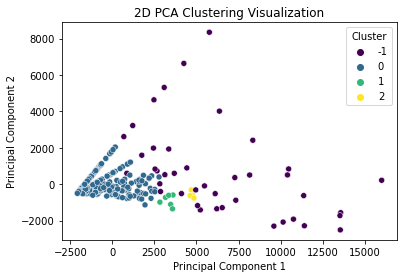

In [54]:
# PCA and visualization
pca_2d_visualization(X_hc, labels)

### Observations from DBSCAN

#### Experimentation

- **Experiment 1: `eps=350`, `min_samples=3`**
   - **Clusters created:** 8
   - **Noise:** 20%
   
- **Experiment 2: `eps=350`, `min_samples=5`**
   - **Clusters created:** 4
   - **Noise:** 25%
   
- **Experiment 3: `eps=600`, `min_samples=3`**
   - **Clusters created:** 4 (One major cluster containing 92% of the data)
   - **Noise:** 9%
   
- **Experiment 4: `eps=600`, `min_samples=5`**
   - **Clusters created:** 1
   - **Noise:** 12%
   
#### Interpretations

- **Noise vs Clusters:** 
   - Lower `eps` and `min_samples` values result in more clusters but also higher noise.
   - Increasing `eps` and `min_samples` decreases noise but increases the size of the main cluster, making it less discriminative.

- **Major Cluster Dominance:** 
   - Higher `eps` values tend to create a dominant cluster that encompasses the majority of data points, leaving less room for nuanced cluster differentiation.

- **Outliers:** 
   - DBSCAN seems to recognize a significant percentage of data points as outliers. Adjusting parameters can reduce this, but it then tends to create oversized clusters.

### Conclusions and Suggestions

- **Comparison with Other Methods:** K-Means and Hierarchical Clustering seem to provide clearer, more interpretable clusters compared to DBSCAN in this case.

- **Parameter Tuning:** Despite various attempts at tuning DBSCAN parameters, achieving a balanced and meaningful cluster distribution proved challenging.

- **Consideration of Outliers:** DBSCAN’s sensitivity to outliers could be useful in certain scenarios, but in this case, it seemed to detract from achieving well-differentiated clusters.

- **Final Thoughts:** It might be more beneficial to rely on K-Means or Hierarchical Clustering for this dataset due to their ability to create more distinct and interpretable clusters. DBSCAN could be revisited with different parameter settings or for datasets where identifying outliers is a major concern.


# Compare and analyze clusters: K-Mean and Hierarchical Clustering

## Consistency of Cluster Assignments

In [55]:
def compare_clusters(df_labeled, method1_label, method2_label):
    """
    This function creates and prints a contingency matrix to compare cluster assignments
    from two different clustering methods.

    Parameters:
    df_labeled: DataFrame containing the cluster labels from both clustering methods.
    method1_label: String, column name for the first clustering method's labels.
    method2_label: String, column name for the second clustering method's labels.

    Returns:
    A contingency matrix as a DataFrame.
    """
    labels_1 = df_labeled[method1_label]
    labels_2 = df_labeled[method2_label]
    cont_matrix = contingency_matrix(labels_1, labels_2)

    cont_df = pd.DataFrame(cont_matrix, 
                           columns=[f'{method2_label}_{i}' for i in range(cont_matrix.shape[1])],
                           index=[f'{method1_label}_{i}' for i in range(cont_matrix.shape[0])])

    print(cont_df)
    return cont_df

In [56]:
cont_df_3_clusters = compare_clusters(df_labeled, 'kmean_3', 'hc_3')

           hc_3_0  hc_3_1  hc_3_2
kmean_3_0      83       0       0
kmean_3_1      48       0     267
kmean_3_2       5      11       0


In [57]:
cont_df_4_clusters = compare_clusters(df_labeled, 'kmean_4', 'hc_4')

           hc_4_0  hc_4_1  hc_4_2  hc_4_3
kmean_4_0       0      18     267       0
kmean_4_1       0       0       0      11
kmean_4_2       4      87       0       0
kmean_4_3      27       0       0       0


In [58]:
cont_df_5_clusters = compare_clusters(df_labeled, 'kmean_5', 'hc_5')

           hc_5_0  hc_5_1  hc_5_2  hc_5_3  hc_5_4
kmean_5_0      16       0     267       0       0
kmean_5_1       0      23       0       0       0
kmean_5_2       0       1       0       0       4
kmean_5_3       0       0       0      11       0
kmean_5_4      89       3       0       0       0


### Cluster Analysis Summary

#### 3-Cluster Solution Summary:

- **KMeans Cluster 0**: Perfect alignment with Hierarchical Cluster 0.
- **KMeans Cluster 1**: Majority aligned with Hierarchical Cluster 2, with some data points in Hierarchical Cluster 0, indicating a strong but not exclusive match.
- **KMeans Cluster 2**: has a minor alignment with **Hierarchical Clusters 0** and **1**, but the majority of data points are not shared.

#### 4-Cluster Solution Summary:

- **KMeans Cluster 0**: Predominantly aligns with Hierarchical Cluster 2, with a minor alignment with Hierarchical Cluster 1.
- **KMeans Cluster 1**: Perfectly matches with Hierarchical Cluster 3, suggesting a unique and distinct cluster identified by both clustering methods.
- **KMeans Cluster 2**: Mostly aligns with Hierarchical Cluster 1, with a few outliers aligning with Hierarchical Cluster 0.
- **KMeans Cluster 3**: Completely aligns with Hierarchical Cluster 0, further validating this cluster across both methods.

#### 5-Cluster Solution Summary:

- **KMeans Cluster 0**: Dominantly corresponds with Hierarchical Cluster 2, with nearly all members clustered together by both methods.
- **KMeans Cluster 1**: Matches Hierarchical Cluster 1 exactly, indicating strong agreement between KMeans and Hierarchical clustering for this group.
- **KMeans Cluster 2**: A small cluster with members primarily in Hierarchical Cluster 4, indicating a potential sub-segment.
- **KMeans Cluster 3**: Shows a perfect one-to-one relationship with Hierarchical Cluster 3.
- **KMeans Cluster 4**: Primarily consists of members from Hierarchical Cluster 0, with a few in Cluster 1.

**General Observations**:

- Consistency between KMeans and Hierarchical Clustering varies with the number of clusters, a common finding in cluster analysis.
- Some KMeans clusters align well with Hierarchical Clusters, suggesting agreement between the clustering methods.
- Clusters with near-perfect alignment across methods could indicate robust segments.
- Discrepancies may highlight where one method is capturing more nuanced data relationships than the other.
- The choice of the number of clusters can significantly affect the alignment and interpretation of results.


## Internal Validation Metrics

In [59]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def calculate_internal_validation_metrics(X, kmeans_labels, hierarch_labels):
    # Calculate the silhouette scores
    kmeans_silhouette = silhouette_score(X, kmeans_labels)
    hierarch_silhouette = silhouette_score(X, hierarch_labels)

    # Calculate the Calinski-Harabasz scores
    kmeans_calinski = calinski_harabasz_score(X, kmeans_labels)
    hierarch_calinski = calinski_harabasz_score(X, hierarch_labels)

    # Calculate the Davies-Bouldin scores
    kmeans_davies = davies_bouldin_score(X, kmeans_labels)
    hierarch_davies = davies_bouldin_score(X, hierarch_labels)

    # Print out the scores
    print(f"K-Means Silhouette Score: {kmeans_silhouette}")
    print(f"Hierarchical Silhouette Score: {hierarch_silhouette}")
    print(f"K-Means Calinski-Harabasz Index: {kmeans_calinski}")
    print(f"Hierarchical Calinski-Harabasz Index: {hierarch_calinski}")
    print(f"K-Means Davies-Bouldin Index: {kmeans_davies}")
    print(f"Hierarchical Davies-Bouldin Index: {hierarch_davies}")

    # Alternatively, return the scores in a structured format
    return {
        'kmeans_silhouette': kmeans_silhouette,
        'hierarch_silhouette': hierarch_silhouette,
        'kmeans_calinski': kmeans_calinski,
        'hierarch_calinski': hierarch_calinski,
        'kmeans_davies': kmeans_davies,
        'hierarch_davies': hierarch_davies
    }


In [60]:
# Example usage:
# Assuming X, kmeans_labels, and hierarch_labels are already defined
X_copy = joined_df.copy()
metrics = calculate_internal_validation_metrics(X_copy, df_labeled['kmean_3'], df_labeled['hc_3'])


K-Means Silhouette Score: 0.6288572139124661
Hierarchical Silhouette Score: 0.5456061071080882
K-Means Calinski-Harabasz Index: 674.1739320365587
Hierarchical Calinski-Harabasz Index: 516.9919313236114
K-Means Davies-Bouldin Index: 0.6703469170557442
Hierarchical Davies-Bouldin Index: 0.6679032894911257


In [61]:
# Example usage:
# Assuming X, kmeans_labels, and hierarch_labels are already defined
X_copy = joined_df.copy()
metrics = calculate_internal_validation_metrics(X_copy, df_labeled['kmean_4'], df_labeled['hc_4'])

K-Means Silhouette Score: 0.5719029200514452
Hierarchical Silhouette Score: 0.5460492375090384
K-Means Calinski-Harabasz Index: 643.0549547894597
Hierarchical Calinski-Harabasz Index: 634.5632178994089
K-Means Davies-Bouldin Index: 0.8400029540292979
Hierarchical Davies-Bouldin Index: 0.8326099082550147


In [62]:
# Example usage:
# Assuming X, kmeans_labels, and hierarch_labels are already defined
X_copy = joined_df.copy()
metrics = calculate_internal_validation_metrics(X_copy, df_labeled['kmean_5'], df_labeled['hc_5'])

K-Means Silhouette Score: 0.5787282879436422
Hierarchical Silhouette Score: 0.5563130274575813
K-Means Calinski-Harabasz Index: 674.2397327470921
Hierarchical Calinski-Harabasz Index: 658.3581582247934
K-Means Davies-Bouldin Index: 0.6712011461959337
Hierarchical Davies-Bouldin Index: 0.6738014053648111


### Internal Validation Metrics

#### 3 Clusters
- **K-Means Silhouette Score:** `0.6289` suggests good cluster cohesion and separation.
- **Hierarchical Silhouette Score:** `0.5456` indicates less distinct clusters than K-Means.
- **K-Means Calinski-Harabasz Index:** `674.17` shows well-separated clusters.
- **Hierarchical Calinski-Harabasz Index:** `516.99` suggests less separation than K-Means.
- **K-Means Davies-Bouldin Index:** `0.6703` reflects moderate cluster separation.
- **Hierarchical Davies-Bouldin Index:** `0.6679` is comparable to K-Means, indicating similar cluster compactness and separation.

#### 4 Clusters
- **K-Means Silhouette Score:** `0.5719` implies reasonable cluster structure.
- **Hierarchical Silhouette Score:** `0.5460` is consistent with the 3-cluster solution, indicating stability.
- **K-Means Calinski-Harabasz Index:** `643.05` indicates a slight reduction in cluster quality compared to the 3-cluster solution.
- **Hierarchical Calinski-Harabasz Index:** `634.56` is relatively close to K-Means, suggesting a competitive cluster structure.
- **K-Means Davies-Bouldin Index:** `0.8400` shows a decrease in cluster quality.
- **Hierarchical Davies-Bouldin Index:** `0.8326` reflects a similar decrease.

#### 5 Clusters
- **K-Means Silhouette Score:** `0.5787` shows an improvement in cluster definition over the 4-cluster solution.
- **Hierarchical Silhouette Score:** `0.5563` indicates a slight improvement in cluster cohesion and separation.
- **K-Means Calinski-Harabasz Index:** `674.24` suggests that clusters are well-defined and distinct.
- **Hierarchical Calinski-Harabasz Index:** `658.36` reflects good cluster separation, slightly lower than K-Means.
- **K-Means Davies-Bouldin Index:** `0.6712` suggests reasonable separation between clusters, slightly better than the 4-cluster solution.
- **Hierarchical Davies-Bouldin Index:** `0.6738` shows a marginal improvement, indicating slightly better cluster separation than the 4-cluster configuration.

Overall, K-Means tends to exhibit stronger performance across different numbers of clusters. Both the 3 and 5 cluster configurations show promise, with the K-Means clusters being slightly more well-defined. The decision on the optimal number of clusters should be guided by the application context and the interpretability of the clusters.

<hr style="border: none; border-top: 3px solid black;">

# Project Summary

## Project Goal

The objective was to effectively segment a customer base to enable targeted marketing initiatives, improving customer engagement through personalization.

## Methodology Overview

A structured process guided the segmentation, which included several key steps:

### Data Preprocessing and Feature Engineering

- Addressed outliers, handled missing values, and converted data types for consistency.
- Engineered new features, streamlined country information, and developed a recency metric.
- Employed PCA for feature transformation on `StockCode`, optimizing input for clustering.

### Clustering Execution and Analysis

1. **K-Means Clustering**: 
    - Applied the Elbow Method and Silhouette Scores to identify optimal cluster counts (3, 4, and 5 clusters).
    - Examined cluster sizes and performed feature analysis to understand the top 20 feature distributions.
    - Conducted PCA 2D visualizations to interpret the spatial distribution of clusters and centroids for each cluster count.

2. **Hierarchical Clustering**: 
    - Utilized Dendrograms to determine suitable cluster counts (3, 4, and 5 clusters).
    - Analyzed cluster sizes and assessed feature distributions for the top 20 features.
    - Performed PCA 2D visualizations to evaluate the labels for each cluster count.

3. **DBSCAN**:
    - Conducted multiple experiments adjusting `eps` and `min_samples`.
    - Implemented PCA visualizations to observe customer segmentation and identify outliers.
    - Evaluated the efficacy of customer segmentation by reviewing cluster sizes.

4. **Consistency of Cluster Assignments**:
    - Compared the alignment of clusters between K-Means and Hierarchical Clustering for 3, 4, and 5 clusters to gauge consistency.

5. **Internal Validation Metrics**:
    - Utilized Silhouette Scores, Calinski-Harabasz Scores, and Davies-Bouldin Scores to compare the clustering quality between K-Means and Hierarchical Clustering across different cluster counts.

### Observations and Evaluation

- An analysis of cluster sizes and internal validation metrics provided insights into the segmentation quality and customer behaviors.
- Visual evaluations through PCA offered a clear understanding of cluster formation and separation.
- K-Means and Hierarchical Clustering demonstrated variable alignment, with the choice of cluster count significantly impacting the results.

### Conclusions and Future Directions

- The project yielded significant insights into customer segmentation, advocating the use of K-Means and Hierarchical Clustering methods over DBSCAN for this particular dataset.
- While K-Means delivered slightly more distinct clusters, both clustering methods showed potential in different aspects of the analysis.

## Future Steps

- **In-depth Cluster Analysis**: Characterize each cluster in detail to understand the unique customer profiles.
- **Targeted Marketing Strategies**: Develop specific strategies based on cluster characteristics to increase engagement.
- **Model Enhancement**: Refine the segmentation model with new customer data to improve clustering accuracy.
- **Predictive Analytics**: Leverage clustering insights to forecast future purchasing behaviors.
- **Geographic Adjustments**: Customize marketing strategies according to the geographical distribution of clusters.
- **Outlier Management**: Further explore outlier behaviors to fine-tune customer segmentation.



In [63]:
df_labeled[['kmean_3', 'kmean_4', 'kmean_5']]

,kmean_3,kmean_4,kmean_5
CustomerID,,,
12347,0,2,4
12348,1,0,0
12349,1,2,4
12350,1,0,0
12352,1,0,0
...,...,...,...
17444,1,2,4
17508,1,0,0
17828,1,0,0
